In [1]:
import tensorflow as tf
import yfinance as yf
from yahoo_fin.stock_info import get_data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
# Imports 3 years of BTC daily data from yahoo finance
BTC_df = get_data("BTC-USD", start_date="6/30/2019", end_date="06/30/2022", index_as_date = True, interval="1d")
df = BTC_df.iloc[:,0:-1]
df.head()

,open,high,low,close,adjclose,volume
2019-06-30,11931.991211,12178.383789,10799.008789,10817.155273,10817.155273,27256473494
2019-07-01,10796.930664,11206.439453,10089.314453,10583.134766,10583.134766,29378589324
2019-07-02,10588.683594,10912.188477,9737.884766,10801.677734,10801.677734,31015895223
2019-07-03,10818.156250,11968.078125,10818.156250,11961.269531,11961.269531,30796494294
2019-07-04,11972.718750,12006.075195,11166.569336,11215.437500,11215.437500,25920294033


In [3]:
# Defines function to split X and y data
def window_data(df, window, feature_col_number, target_col_number):
    # Creates empty X and y list
    X = []
    y = []
    # loops through btc data
    for i in range(len(df) - window - 1):
        # splits the features by grouping window amount of previous close data
        features = df.iloc[i:(i + window), feature_col_number]
        # splits target by taking current close values
        target = df.iloc[(i + window), target_col_number]
        # Adds end of each loops data to respective X and y list
        X.append(features)
        y.append(target)
    # returns X,y as arrays
    return np.array(X), np.array(y).reshape(-1, 1)

In [4]:
# Defines window size
window_size=10

In [5]:
# Runs function to split X and y data
X, y=window_data(df, window_size, 3, 3)
# Displays X and y
display(X)
display(y)

array([[10817.15527344, 10583.13476562, 10801.67773438, ...,
        11450.84667969, 12285.95800781, 12573.8125    ],
       [10583.13476562, 10801.67773438, 11961.26953125, ...,
        12285.95800781, 12573.8125    , 12156.51269531],
       [10801.67773438, 11961.26953125, 11215.4375    , ...,
        12573.8125    , 12156.51269531, 11358.66210938],
       ...,
       [20471.48242188, 19017.64257812, 20553.27148438, ...,
        21231.65625   , 21502.33789062, 21027.29492188],
       [19017.64257812, 20553.27148438, 20599.53710938, ...,
        21502.33789062, 21027.29492188, 20735.47851562],
       [20553.27148438, 20599.53710938, 20710.59765625, ...,
        21027.29492188, 20735.47851562, 20280.63476562]])

array([[12156.51269531],
       [11358.66210938],
       [11815.98632812],
       ...,
       [20735.47851562],
       [20280.63476562],
       [20104.0234375 ]])

In [6]:
# Scales X and y data using MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X)
X_scaled=X_scaler.transform(X)
y_scaler=MinMaxScaler()
y_scaler.fit(y)
y_scaled=y_scaler.transform(y)

In [7]:
# Defines where train and test data will be split (70% is train)
split=int(0.7*len(X_scaled))
# Splits train and test data
X_train=X_scaled[:split]
X_test=X_scaled[split:]
y_train=y_scaled[:split]
y_test=y_scaled[split:]

In [8]:
#X_scaled=X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
#display(X.shape)

In [9]:
# Reshapes data into size LSTM can handle
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
display(X_train.shape)
display(X_test.shape)

(760, 10, 1)

(326, 10, 1)

In [10]:
# Creates neural network
model=Sequential()
# Defines and adds LSTM layer
first_lstm_layer=LSTM(units=30, return_sequences=True, input_shape=(window_size, 1))
model.add(first_lstm_layer)
# Randomly drops 20% of defined nodes
first_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model.add(first_dropout_layer)
second_lstm_layer=LSTM(units=30, return_sequences=True)
model.add(second_lstm_layer)
# Randomly drops 20% of defined nodes
second_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model.add(second_dropout_layer)
third_lstm_layer=LSTM(units=30)
model.add(third_lstm_layer)
# Defines and adds output layer with linear activation
output_layer=Dense(units=1, activation='linear')
model.add(output_layer)

2022-07-12 16:05:31.531816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Compiles model
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [12]:
# Provides summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 10, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 30)            7320      
                                                                 
 dropout_1 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-traina

In [13]:
# Initially fits model using training data
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
24/24 [==============================] - 8s 19ms/step - loss: 0.0479 - mean_squared_error: 0.0479
Epoch 2/50
24/24 [==============================] - 0s 17ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 3/50
24/24 [==============================] - 0s 18ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 4/50
24/24 [==============================] - 0s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 5/50
24/24 [==============================] - 0s 17ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 6/50
24/24 [==============================] - 0s 18ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 7/50
24/24 [==============================] - 1s 21ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 8/50
24/24 [==============================] - 0s 18ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 9/50
24/24 [==============================] - 1s 21ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 10/50
24/24 [

In [14]:
# Projects future data by using model to predict next close and then uses that value to retrain 
# the model before making next prediction
for i in range(326): 
    # predicts next close value and reshapes it
    prediction_scaled=model.predict(X_train[-1].reshape(1, window_size, 1))
    # transforms prediction back to original scale
    next_prediction=y_scaler.inverse_transform(prediction_scaled)
    # displays predicted close value
    display(next_prediction)
    # adds predicted close value to list
    new_train_sample=np.append(X_train[-1], prediction_scaled)[1:].reshape(1, window_size, 1)
    # adds new list entry of predicted close to X train
    X_train=np.append(X_train, new_train_sample, axis=0)
    # adds new list entry of predicted close to y train
    y_train=np.append(y_train, prediction_scaled, axis=0)
    # refits model with new close value
    model.fit(X_train, y_train, epochs=5)

1/1 [==============================] - 2s 2s/step


array([[40989.066]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 2/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3/5
24/24 [==============================] - 0s 19ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/5
24/24 [==============================] - 0s 20ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[41239.09]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 2/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3/5
24/24 [==============================] - 1s 21ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 4/5
24/24 [==============================] - 0s 20ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/5
1/1 [==============================] - 0s 106ms/step


array([[39463.023]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 1s 27ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 2/5
24/24 [==============================] - 1s 22ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3/5
24/24 [==============================] - 1s 21ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 4/5
24/24 [==============================] - 0s 19ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[42541.13]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 1s 23ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 2/5
24/24 [==============================] - 1s 25ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/5
24/24 [==============================] - 1s 22ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 4/5
24/24 [==============================] - 1s 24ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[41652.926]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 2/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3/5
24/24 [==============================] - 1s 22ms/step - loss: 0.0011 - mean_squared_error: 0.0011 
Epoch 4/5
24/24 [==============================] - 1s 21ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


array([[42223.19]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 17ms/step - loss: 9.8405e-04 - mean_squared_error: 9.8405e-04
Epoch 2/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/5
24/24 [==============================] - 0s 17ms/step - loss: 9.8118e-04 - mean_squared_error: 9.8118e-04
Epoch 4/5
24/24 [==============================] - 0s 18ms/step - loss: 9.1040e-04 - mean_squared_error: 9.1040e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[43482.883]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 2/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/5
24/24 [==============================] - 0s 17ms/step - loss: 9.8904e-04 - mean_squared_error: 9.8904e-04
Epoch 4/5
24/24 [==============================] - 0s 17ms/step - loss: 8.8940e-04 - mean_squared_error: 8.8940e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[42893.473]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 18ms/step - loss: 9.3840e-04 - mean_squared_error: 9.3840e-04
Epoch 2/5
24/24 [==============================] - 0s 17ms/step - loss: 9.2895e-04 - mean_squared_error: 9.2895e-04
Epoch 3/5
24/24 [==============================] - 0s 18ms/step - loss: 8.4512e-04 - mean_squared_error: 8.4512e-04
Epoch 4/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0010 - mean_squared_error: 0.0010   
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[42803.953]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 9.7434e-04 - mean_squared_error: 9.7434e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 9.3019e-04 - mean_squared_error: 9.3019e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[44714.54]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 8.5324e-04 - mean_squared_error: 8.5324e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 7.7336e-04 - mean_squared_error: 7.7336e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 0.0010 - mean_squared_error: 0.0010   
Epoch 4/5
25/25 [==============================] - 0s 16ms/step - loss: 9.5888e-04 - mean_squared_error: 9.5888e-04
Epoch 5/5
1/1 [==============================] - 0s 52ms/step


array([[43331.703]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 8.7213e-04 - mean_squared_error: 8.7213e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 9.1610e-04 - mean_squared_error: 9.1610e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 8.5989e-04 - mean_squared_error: 8.5989e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 8.3750e-04 - mean_squared_error: 8.3750e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[43705.336]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 18ms/step - loss: 9.6575e-04 - mean_squared_error: 9.6575e-04
Epoch 2/5
25/25 [==============================] - 1s 27ms/step - loss: 9.0781e-04 - mean_squared_error: 9.0781e-04
Epoch 3/5
25/25 [==============================] - 1s 29ms/step - loss: 8.4488e-04 - mean_squared_error: 8.4488e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 9.1897e-04 - mean_squared_error: 9.1897e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[45205.137]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 18ms/step - loss: 8.2471e-04 - mean_squared_error: 8.2471e-04
Epoch 2/5
25/25 [==============================] - 1s 20ms/step - loss: 9.0111e-04 - mean_squared_error: 9.0111e-04
Epoch 3/5
25/25 [==============================] - 1s 20ms/step - loss: 9.6938e-04 - mean_squared_error: 9.6938e-04
Epoch 4/5
25/25 [==============================] - 1s 19ms/step - loss: 9.2347e-04 - mean_squared_error: 9.2347e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[45234.125]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 18ms/step - loss: 8.1633e-04 - mean_squared_error: 8.1633e-04
Epoch 2/5
25/25 [==============================] - 0s 16ms/step - loss: 9.2052e-04 - mean_squared_error: 9.2052e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 8.1148e-04 - mean_squared_error: 8.1148e-04
Epoch 4/5
25/25 [==============================] - 1s 22ms/step - loss: 8.4637e-04 - mean_squared_error: 8.4637e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[45708.23]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 7.4539e-04 - mean_squared_error: 7.4539e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 8.8528e-04 - mean_squared_error: 8.8528e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 8.2126e-04 - mean_squared_error: 8.2126e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 8.0206e-04 - mean_squared_error: 8.0206e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45072.637]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 7.8750e-04 - mean_squared_error: 7.8750e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.5812e-04 - mean_squared_error: 6.5812e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 6.9132e-04 - mean_squared_error: 6.9132e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 9.0948e-04 - mean_squared_error: 9.0948e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[45605.766]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 7.6286e-04 - mean_squared_error: 7.6286e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.8493e-04 - mean_squared_error: 6.8493e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 7.4243e-04 - mean_squared_error: 7.4243e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 6.8909e-04 - mean_squared_error: 6.8909e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[44907.883]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 8.6009e-04 - mean_squared_error: 8.6009e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.7036e-04 - mean_squared_error: 6.7036e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 7.3397e-04 - mean_squared_error: 7.3397e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 8.1534e-04 - mean_squared_error: 8.1534e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[44531.707]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 16ms/step - loss: 7.1264e-04 - mean_squared_error: 7.1264e-04
Epoch 2/5
25/25 [==============================] - 0s 18ms/step - loss: 6.3237e-04 - mean_squared_error: 6.3237e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 7.7217e-04 - mean_squared_error: 7.7217e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 9.0492e-04 - mean_squared_error: 9.0492e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[44147.06]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 8.8471e-04 - mean_squared_error: 8.8471e-04
Epoch 2/5
25/25 [==============================] - 1s 21ms/step - loss: 9.6640e-04 - mean_squared_error: 9.6640e-04
Epoch 3/5
25/25 [==============================] - 0s 18ms/step - loss: 5.9432e-04 - mean_squared_error: 5.9432e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 7.7261e-04 - mean_squared_error: 7.7261e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[44678.312]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 6.2266e-04 - mean_squared_error: 6.2266e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.8478e-04 - mean_squared_error: 6.8478e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 7.0849e-04 - mean_squared_error: 7.0849e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 9.1311e-04 - mean_squared_error: 9.1311e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[42258.273]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 20ms/step - loss: 7.6668e-04 - mean_squared_error: 7.6668e-04
Epoch 2/5
25/25 [==============================] - 1s 21ms/step - loss: 6.3428e-04 - mean_squared_error: 6.3428e-04
Epoch 3/5
25/25 [==============================] - 1s 22ms/step - loss: 7.5317e-04 - mean_squared_error: 7.5317e-04
Epoch 4/5
25/25 [==============================] - 1s 21ms/step - loss: 7.0733e-04 - mean_squared_error: 7.0733e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[44399.754]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 6.6086e-04 - mean_squared_error: 6.6086e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.3198e-04 - mean_squared_error: 6.3198e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 7.2973e-04 - mean_squared_error: 7.2973e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 6.4275e-04 - mean_squared_error: 6.4275e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[43234.984]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 6.3404e-04 - mean_squared_error: 6.3404e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 5.3779e-04 - mean_squared_error: 5.3779e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 5.8152e-04 - mean_squared_error: 5.8152e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 6.0966e-04 - mean_squared_error: 6.0966e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[43156.867]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 18ms/step - loss: 6.1802e-04 - mean_squared_error: 6.1802e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 5.9867e-04 - mean_squared_error: 5.9867e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 5.4206e-04 - mean_squared_error: 5.4206e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 5.8942e-04 - mean_squared_error: 5.8942e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[44657.77]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 20ms/step - loss: 7.1538e-04 - mean_squared_error: 7.1538e-04
Epoch 2/5
25/25 [==============================] - 0s 20ms/step - loss: 5.9759e-04 - mean_squared_error: 5.9759e-04
Epoch 3/5
25/25 [==============================] - 0s 19ms/step - loss: 6.9200e-04 - mean_squared_error: 6.9200e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 7.1758e-04 - mean_squared_error: 7.1758e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[43702.723]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 20ms/step - loss: 6.0923e-04 - mean_squared_error: 6.0923e-04
Epoch 2/5
25/25 [==============================] - 0s 20ms/step - loss: 6.3656e-04 - mean_squared_error: 6.3656e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 7.0161e-04 - mean_squared_error: 7.0161e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 8.0716e-04 - mean_squared_error: 8.0716e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[43975.812]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 5.1214e-04 - mean_squared_error: 5.1214e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.4066e-04 - mean_squared_error: 6.4066e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 5.4715e-04 - mean_squared_error: 5.4715e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 5.9623e-04 - mean_squared_error: 5.9623e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[43843.71]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 5.9349e-04 - mean_squared_error: 5.9349e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.8625e-04 - mean_squared_error: 6.8625e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 7.6948e-04 - mean_squared_error: 7.6948e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 7.5989e-04 - mean_squared_error: 7.5989e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45152.516]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 6.5941e-04 - mean_squared_error: 6.5941e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 5.7324e-04 - mean_squared_error: 5.7324e-04
Epoch 3/5
25/25 [==============================] - 0s 16ms/step - loss: 6.5496e-04 - mean_squared_error: 6.5496e-04
Epoch 4/5
25/25 [==============================] - 0s 16ms/step - loss: 5.4683e-04 - mean_squared_error: 5.4683e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45001.773]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 16ms/step - loss: 5.5165e-04 - mean_squared_error: 5.5165e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.2823e-04 - mean_squared_error: 6.2823e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 6.1945e-04 - mean_squared_error: 6.1945e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 5.3962e-04 - mean_squared_error: 5.3962e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[45717.97]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 16ms/step - loss: 6.0581e-04 - mean_squared_error: 6.0581e-04
Epoch 2/5
25/25 [==============================] - 0s 16ms/step - loss: 6.5369e-04 - mean_squared_error: 6.5369e-04
Epoch 3/5
25/25 [==============================] - 0s 16ms/step - loss: 6.4335e-04 - mean_squared_error: 6.4335e-04
Epoch 4/5
25/25 [==============================] - 0s 16ms/step - loss: 5.7152e-04 - mean_squared_error: 5.7152e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47369.11]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 5.7902e-04 - mean_squared_error: 5.7902e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.5140e-04 - mean_squared_error: 6.5140e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 5.2063e-04 - mean_squared_error: 5.2063e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 6.9364e-04 - mean_squared_error: 6.9364e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46878.324]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 5.2397e-04 - mean_squared_error: 5.2397e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 5.7330e-04 - mean_squared_error: 5.7330e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 5.6557e-04 - mean_squared_error: 5.6557e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 5.6548e-04 - mean_squared_error: 5.6548e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47535.887]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 5.5748e-04 - mean_squared_error: 5.5748e-04
Epoch 2/5
25/25 [==============================] - 0s 16ms/step - loss: 6.4175e-04 - mean_squared_error: 6.4175e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 5.3976e-04 - mean_squared_error: 5.3976e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 5.4110e-04 - mean_squared_error: 5.4110e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47607.945]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 6.1078e-04 - mean_squared_error: 6.1078e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.0472e-04 - mean_squared_error: 6.0472e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 5.2714e-04 - mean_squared_error: 5.2714e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 5.9690e-04 - mean_squared_error: 5.9690e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[49269.508]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 6.3908e-04 - mean_squared_error: 6.3908e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 7.1140e-04 - mean_squared_error: 7.1140e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 5.6864e-04 - mean_squared_error: 5.6864e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 5.6139e-04 - mean_squared_error: 5.6139e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[49891.875]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 6.7065e-04 - mean_squared_error: 6.7065e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.6716e-04 - mean_squared_error: 6.6716e-04
Epoch 3/5
25/25 [==============================] - 0s 16ms/step - loss: 5.7124e-04 - mean_squared_error: 5.7124e-04
Epoch 4/5
25/25 [==============================] - 0s 16ms/step - loss: 6.3894e-04 - mean_squared_error: 6.3894e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[49093.176]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 5.1820e-04 - mean_squared_error: 5.1820e-04
Epoch 2/5
25/25 [==============================] - 0s 16ms/step - loss: 5.0600e-04 - mean_squared_error: 5.0600e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 5.4597e-04 - mean_squared_error: 5.4597e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 5.9023e-04 - mean_squared_error: 5.9023e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[49547.203]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 5.4750e-04 - mean_squared_error: 5.4750e-04
Epoch 2/5
25/25 [==============================] - 0s 16ms/step - loss: 5.9479e-04 - mean_squared_error: 5.9479e-04
Epoch 3/5
25/25 [==============================] - 0s 16ms/step - loss: 4.8979e-04 - mean_squared_error: 4.8979e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 6.3682e-04 - mean_squared_error: 6.3682e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[49883.59]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.2108e-04 - mean_squared_error: 5.2108e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 8.2238e-04 - mean_squared_error: 8.2238e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.9384e-04 - mean_squared_error: 4.9384e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 7.3828e-04 - mean_squared_error: 7.3828e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[50160.113]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 6.2757e-04 - mean_squared_error: 6.2757e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 5.3536e-04 - mean_squared_error: 5.3536e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.0542e-04 - mean_squared_error: 5.0542e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 6.1202e-04 - mean_squared_error: 6.1202e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[48781.03]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 6.5136e-04 - mean_squared_error: 6.5136e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 4.7401e-04 - mean_squared_error: 4.7401e-04
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 5.3020e-04 - mean_squared_error: 5.3020e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.3810e-04 - mean_squared_error: 5.3810e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[48620.203]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.6702e-04 - mean_squared_error: 5.6702e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 5.1790e-04 - mean_squared_error: 5.1790e-04
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 5.1099e-04 - mean_squared_error: 5.1099e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 4.9340e-04 - mean_squared_error: 4.9340e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[48678.133]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.3654e-04 - mean_squared_error: 5.3654e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 5.2021e-04 - mean_squared_error: 5.2021e-04
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 5.2545e-04 - mean_squared_error: 5.2545e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.4170e-04 - mean_squared_error: 5.4170e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47031.508]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 6.7301e-04 - mean_squared_error: 6.7301e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 5.0913e-04 - mean_squared_error: 5.0913e-04
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 6.2855e-04 - mean_squared_error: 6.2855e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.4320e-04 - mean_squared_error: 5.4320e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[47842.457]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 18ms/step - loss: 5.2200e-04 - mean_squared_error: 5.2200e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 5.4838e-04 - mean_squared_error: 5.4838e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 6.9075e-04 - mean_squared_error: 6.9075e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.2562e-04 - mean_squared_error: 5.2562e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48644.508]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.5787e-04 - mean_squared_error: 5.5787e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 5.7696e-04 - mean_squared_error: 5.7696e-04
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 5.5692e-04 - mean_squared_error: 5.5692e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 5.2188e-04 - mean_squared_error: 5.2188e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[49235.402]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 16ms/step - loss: 4.9055e-04 - mean_squared_error: 4.9055e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 4.6400e-04 - mean_squared_error: 4.6400e-04
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 4.9660e-04 - mean_squared_error: 4.9660e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 4.9675e-04 - mean_squared_error: 4.9675e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[48867.113]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 16ms/step - loss: 4.7401e-04 - mean_squared_error: 4.7401e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 6.0370e-04 - mean_squared_error: 6.0370e-04
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 5.4830e-04 - mean_squared_error: 5.4830e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.3441e-04 - mean_squared_error: 5.3441e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[49316.25]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.1681e-04 - mean_squared_error: 5.1681e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 4.4675e-04 - mean_squared_error: 4.4675e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.0743e-04 - mean_squared_error: 5.0743e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 4.6072e-04 - mean_squared_error: 4.6072e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[49761.1]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.8345e-04 - mean_squared_error: 4.8345e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 4.8393e-04 - mean_squared_error: 4.8393e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.2009e-04 - mean_squared_error: 5.2009e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.5323e-04 - mean_squared_error: 5.5323e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48564.22]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 16ms/step - loss: 4.8731e-04 - mean_squared_error: 4.8731e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 4.4747e-04 - mean_squared_error: 4.4747e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.1318e-04 - mean_squared_error: 5.1318e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 6.0255e-04 - mean_squared_error: 6.0255e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48084.793]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 16ms/step - loss: 5.0167e-04 - mean_squared_error: 5.0167e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 4.7786e-04 - mean_squared_error: 4.7786e-04
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 4.7789e-04 - mean_squared_error: 4.7789e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 5.2231e-04 - mean_squared_error: 5.2231e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[48977.445]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.6911e-04 - mean_squared_error: 4.6911e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 4.1294e-04 - mean_squared_error: 4.1294e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.2428e-04 - mean_squared_error: 5.2428e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 5.0161e-04 - mean_squared_error: 5.0161e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[49453.34]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.6753e-04 - mean_squared_error: 4.6753e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 4.9246e-04 - mean_squared_error: 4.9246e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.4051e-04 - mean_squared_error: 5.4051e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 4.5152e-04 - mean_squared_error: 4.5152e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[48865.133]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.2991e-04 - mean_squared_error: 4.2991e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 5.0547e-04 - mean_squared_error: 5.0547e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.6640e-04 - mean_squared_error: 4.6640e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.2531e-04 - mean_squared_error: 5.2531e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[49455.65]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.2826e-04 - mean_squared_error: 4.2826e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 4.8137e-04 - mean_squared_error: 4.8137e-04
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 5.1206e-04 - mean_squared_error: 5.1206e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 5.4165e-04 - mean_squared_error: 5.4165e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[48975.996]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.2761e-04 - mean_squared_error: 4.2761e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 5.3737e-04 - mean_squared_error: 5.3737e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.4715e-04 - mean_squared_error: 4.4715e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 4.7638e-04 - mean_squared_error: 4.7638e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[49082.824]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.2221e-04 - mean_squared_error: 4.2221e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 4.1827e-04 - mean_squared_error: 4.1827e-04
Epoch 3/5
26/26 [==============================] - 0s 16ms/step - loss: 4.2900e-04 - mean_squared_error: 4.2900e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 4.7872e-04 - mean_squared_error: 4.7872e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47931.316]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.2295e-04 - mean_squared_error: 5.2295e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 5.1506e-04 - mean_squared_error: 5.1506e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.4355e-04 - mean_squared_error: 4.4355e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 4.3856e-04 - mean_squared_error: 4.3856e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47657.28]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.1707e-04 - mean_squared_error: 5.1707e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 4.5562e-04 - mean_squared_error: 4.5562e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.3386e-04 - mean_squared_error: 4.3386e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 4.6436e-04 - mean_squared_error: 4.6436e-04
Epoch 5/5
1/1 [==============================] - 0s 54ms/step


array([[48320.84]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 16ms/step - loss: 4.2819e-04 - mean_squared_error: 4.2819e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 4.2327e-04 - mean_squared_error: 4.2327e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.4960e-04 - mean_squared_error: 5.4960e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 4.9207e-04 - mean_squared_error: 4.9207e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48650.195]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 20ms/step - loss: 4.6874e-04 - mean_squared_error: 4.6874e-04
Epoch 2/5
26/26 [==============================] - 1s 19ms/step - loss: 4.8633e-04 - mean_squared_error: 4.8633e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.4522e-04 - mean_squared_error: 4.4522e-04
Epoch 4/5
26/26 [==============================] - 1s 20ms/step - loss: 4.8115e-04 - mean_squared_error: 4.8115e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[47841.305]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 24ms/step - loss: 4.4245e-04 - mean_squared_error: 4.4245e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 4.7925e-04 - mean_squared_error: 4.7925e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.2427e-04 - mean_squared_error: 5.2427e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 4.3324e-04 - mean_squared_error: 4.3324e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47881.63]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.8185e-04 - mean_squared_error: 4.8185e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 4.6925e-04 - mean_squared_error: 4.6925e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.6843e-04 - mean_squared_error: 4.6843e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 4.7081e-04 - mean_squared_error: 4.7081e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[48203.94]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.3274e-04 - mean_squared_error: 4.3274e-04
Epoch 2/5
26/26 [==============================] - 0s 16ms/step - loss: 5.8165e-04 - mean_squared_error: 5.8165e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.8012e-04 - mean_squared_error: 4.8012e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 4.4586e-04 - mean_squared_error: 4.4586e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47872.773]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.4254e-04 - mean_squared_error: 4.4254e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 4.6570e-04 - mean_squared_error: 4.6570e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.7544e-04 - mean_squared_error: 5.7544e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.1685e-04 - mean_squared_error: 5.1685e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48729.465]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.7141e-04 - mean_squared_error: 4.7141e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 4.4045e-04 - mean_squared_error: 4.4045e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.1171e-04 - mean_squared_error: 4.1171e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 4.3568e-04 - mean_squared_error: 4.3568e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47494.89]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.6774e-04 - mean_squared_error: 4.6774e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 4.8070e-04 - mean_squared_error: 4.8070e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.1694e-04 - mean_squared_error: 4.1694e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 4.4838e-04 - mean_squared_error: 4.4838e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[49076.992]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.2154e-04 - mean_squared_error: 4.2154e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 4.2986e-04 - mean_squared_error: 4.2986e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.5166e-04 - mean_squared_error: 4.5166e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 4.5362e-04 - mean_squared_error: 4.5362e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48885.223]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 4.2928e-04 - mean_squared_error: 4.2928e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 4.2322e-04 - mean_squared_error: 4.2322e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.4901e-04 - mean_squared_error: 4.4901e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 4.6527e-04 - mean_squared_error: 4.6527e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47599.734]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.6490e-04 - mean_squared_error: 4.6490e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1397e-04 - mean_squared_error: 4.1397e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.2237e-04 - mean_squared_error: 4.2237e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.8357e-04 - mean_squared_error: 3.8357e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47352.418]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.7153e-04 - mean_squared_error: 4.7153e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9189e-04 - mean_squared_error: 3.9189e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1669e-04 - mean_squared_error: 4.1669e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.4073e-04 - mean_squared_error: 4.4073e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47624.13]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0276e-04 - mean_squared_error: 4.0276e-04
Epoch 2/5
27/27 [==============================] - 0s 16ms/step - loss: 4.2431e-04 - mean_squared_error: 4.2431e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0822e-04 - mean_squared_error: 4.0822e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.9751e-04 - mean_squared_error: 4.9751e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47498.29]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.2545e-04 - mean_squared_error: 4.2545e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1198e-04 - mean_squared_error: 4.1198e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.3553e-04 - mean_squared_error: 4.3553e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.2391e-04 - mean_squared_error: 4.2391e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47209.66]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 18ms/step - loss: 3.9133e-04 - mean_squared_error: 3.9133e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9243e-04 - mean_squared_error: 3.9243e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.3494e-04 - mean_squared_error: 4.3494e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.2099e-04 - mean_squared_error: 4.2099e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47173.484]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.4463e-04 - mean_squared_error: 4.4463e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.2478e-04 - mean_squared_error: 4.2478e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 3.8804e-04 - mean_squared_error: 3.8804e-04
Epoch 4/5
27/27 [==============================] - 0s 16ms/step - loss: 3.9121e-04 - mean_squared_error: 3.9121e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47224.543]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.9361e-04 - mean_squared_error: 4.9361e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.2899e-04 - mean_squared_error: 4.2899e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.9669e-04 - mean_squared_error: 4.9669e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.6926e-04 - mean_squared_error: 4.6926e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[46695.867]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7727e-04 - mean_squared_error: 3.7727e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.8248e-04 - mean_squared_error: 4.8248e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.4093e-04 - mean_squared_error: 4.4093e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0067e-04 - mean_squared_error: 4.0067e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47318.227]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9203e-04 - mean_squared_error: 3.9203e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.3890e-04 - mean_squared_error: 4.3890e-04
Epoch 3/5
27/27 [==============================] - 1s 19ms/step - loss: 4.7686e-04 - mean_squared_error: 4.7686e-04
Epoch 4/5
27/27 [==============================] - 1s 19ms/step - loss: 4.2692e-04 - mean_squared_error: 4.2692e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[47590.754]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0059e-04 - mean_squared_error: 4.0059e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7588e-04 - mean_squared_error: 3.7588e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7972e-04 - mean_squared_error: 3.7972e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7724e-04 - mean_squared_error: 3.7724e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47891.832]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.4484e-04 - mean_squared_error: 4.4484e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0705e-04 - mean_squared_error: 4.0705e-04
Epoch 3/5
27/27 [==============================] - 1s 19ms/step - loss: 5.3096e-04 - mean_squared_error: 5.3096e-04
Epoch 4/5
27/27 [==============================] - 1s 21ms/step - loss: 4.6130e-04 - mean_squared_error: 4.6130e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48747.438]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7944e-04 - mean_squared_error: 3.7944e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.6197e-04 - mean_squared_error: 3.6197e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9077e-04 - mean_squared_error: 3.9077e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.9149e-04 - mean_squared_error: 4.9149e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[48976.336]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0865e-04 - mean_squared_error: 4.0865e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9715e-04 - mean_squared_error: 3.9715e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0064e-04 - mean_squared_error: 4.0064e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 5.0142e-04 - mean_squared_error: 5.0142e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[49866.016]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.2016e-04 - mean_squared_error: 4.2016e-04
Epoch 2/5
27/27 [==============================] - 0s 16ms/step - loss: 4.6968e-04 - mean_squared_error: 4.6968e-04
Epoch 3/5
27/27 [==============================] - 0s 16ms/step - loss: 3.8006e-04 - mean_squared_error: 3.8006e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1406e-04 - mean_squared_error: 4.1406e-04
Epoch 5/5
1/1 [==============================] - 0s 105ms/step


array([[49611.535]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.8962e-04 - mean_squared_error: 3.8962e-04
Epoch 2/5
27/27 [==============================] - 0s 16ms/step - loss: 3.9790e-04 - mean_squared_error: 3.9790e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 4.2336e-04 - mean_squared_error: 4.2336e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 3.8864e-04 - mean_squared_error: 3.8864e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[50276.09]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 31ms/step - loss: 3.9462e-04 - mean_squared_error: 3.9462e-04
Epoch 2/5
27/27 [==============================] - 1s 20ms/step - loss: 3.6674e-04 - mean_squared_error: 3.6674e-04
Epoch 3/5
27/27 [==============================] - 1s 20ms/step - loss: 4.1332e-04 - mean_squared_error: 4.1332e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.6231e-04 - mean_squared_error: 3.6231e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[50014.938]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.7744e-04 - mean_squared_error: 4.7744e-04
Epoch 2/5
27/27 [==============================] - 0s 16ms/step - loss: 4.3413e-04 - mean_squared_error: 4.3413e-04
Epoch 3/5
27/27 [==============================] - 0s 16ms/step - loss: 4.0932e-04 - mean_squared_error: 4.0932e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7082e-04 - mean_squared_error: 3.7082e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[49723.68]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1564e-04 - mean_squared_error: 4.1564e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.5036e-04 - mean_squared_error: 3.5036e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9421e-04 - mean_squared_error: 3.9421e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.2794e-04 - mean_squared_error: 4.2794e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48838.918]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.6458e-04 - mean_squared_error: 4.6458e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.8803e-04 - mean_squared_error: 3.8803e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7891e-04 - mean_squared_error: 3.7891e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1677e-04 - mean_squared_error: 4.1677e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[48733.387]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.4713e-04 - mean_squared_error: 4.4713e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0803e-04 - mean_squared_error: 4.0803e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7213e-04 - mean_squared_error: 3.7213e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9658e-04 - mean_squared_error: 3.9658e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[49630.96]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.8432e-04 - mean_squared_error: 3.8432e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.8816e-04 - mean_squared_error: 3.8816e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7194e-04 - mean_squared_error: 3.7194e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7570e-04 - mean_squared_error: 3.7570e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[49693.66]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7114e-04 - mean_squared_error: 3.7114e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.5743e-04 - mean_squared_error: 4.5743e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9412e-04 - mean_squared_error: 3.9412e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9857e-04 - mean_squared_error: 3.9857e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[50158.965]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.7148e-04 - mean_squared_error: 4.7148e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1221e-04 - mean_squared_error: 4.1221e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 3.8887e-04 - mean_squared_error: 3.8887e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.3709e-04 - mean_squared_error: 4.3709e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[50051.18]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.4420e-04 - mean_squared_error: 3.4420e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.8279e-04 - mean_squared_error: 3.8279e-04
Epoch 3/5
27/27 [==============================] - 0s 16ms/step - loss: 3.8535e-04 - mean_squared_error: 3.8535e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9848e-04 - mean_squared_error: 3.9848e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[50637.36]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 16ms/step - loss: 4.0752e-04 - mean_squared_error: 4.0752e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.4626e-04 - mean_squared_error: 3.4626e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0044e-04 - mean_squared_error: 4.0044e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0380e-04 - mean_squared_error: 4.0380e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[50569.652]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 16ms/step - loss: 4.0123e-04 - mean_squared_error: 4.0123e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.8577e-04 - mean_squared_error: 3.8577e-04
Epoch 3/5
27/27 [==============================] - 0s 16ms/step - loss: 4.0294e-04 - mean_squared_error: 4.0294e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.4806e-04 - mean_squared_error: 3.4806e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[51809.6]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0465e-04 - mean_squared_error: 4.0465e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.4295e-04 - mean_squared_error: 4.4295e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0336e-04 - mean_squared_error: 4.0336e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7557e-04 - mean_squared_error: 3.7557e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[52338.508]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7579e-04 - mean_squared_error: 3.7579e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0014e-04 - mean_squared_error: 4.0014e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 3.5563e-04 - mean_squared_error: 3.5563e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1465e-04 - mean_squared_error: 4.1465e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[51960.113]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.6233e-04 - mean_squared_error: 3.6233e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7733e-04 - mean_squared_error: 3.7733e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9653e-04 - mean_squared_error: 3.9653e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0375e-04 - mean_squared_error: 4.0375e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[52553.367]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.6421e-04 - mean_squared_error: 3.6421e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.4696e-04 - mean_squared_error: 4.4696e-04
Epoch 3/5
27/27 [==============================] - 0s 16ms/step - loss: 4.0182e-04 - mean_squared_error: 4.0182e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.7475e-04 - mean_squared_error: 3.7475e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[53266.004]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0797e-04 - mean_squared_error: 4.0797e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1822e-04 - mean_squared_error: 4.1822e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.0572e-04 - mean_squared_error: 4.0572e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 3.6125e-04 - mean_squared_error: 3.6125e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[54155.348]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.8483e-04 - mean_squared_error: 3.8483e-04
Epoch 2/5
27/27 [==============================] - 0s 18ms/step - loss: 3.4671e-04 - mean_squared_error: 3.4671e-04
Epoch 3/5
27/27 [==============================] - 1s 21ms/step - loss: 3.5471e-04 - mean_squared_error: 3.5471e-04
Epoch 4/5
27/27 [==============================] - 1s 20ms/step - loss: 4.5520e-04 - mean_squared_error: 4.5520e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[54497.195]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 20ms/step - loss: 3.4540e-04 - mean_squared_error: 3.4540e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 4.8793e-04 - mean_squared_error: 4.8793e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7597e-04 - mean_squared_error: 3.7597e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8787e-04 - mean_squared_error: 3.8787e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[54371.89]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 20ms/step - loss: 3.6954e-04 - mean_squared_error: 3.6954e-04
Epoch 2/5
28/28 [==============================] - 1s 20ms/step - loss: 3.9910e-04 - mean_squared_error: 3.9910e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 4.3484e-04 - mean_squared_error: 4.3484e-04
Epoch 4/5
28/28 [==============================] - 1s 19ms/step - loss: 4.4055e-04 - mean_squared_error: 4.4055e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[54316.05]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 4.0085e-04 - mean_squared_error: 4.0085e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 4.9630e-04 - mean_squared_error: 4.9630e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8456e-04 - mean_squared_error: 3.8456e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 4.2924e-04 - mean_squared_error: 4.2924e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55773.652]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 16ms/step - loss: 4.6161e-04 - mean_squared_error: 4.6161e-04
Epoch 2/5
28/28 [==============================] - 0s 16ms/step - loss: 4.8340e-04 - mean_squared_error: 4.8340e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 4.0232e-04 - mean_squared_error: 4.0232e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5857e-04 - mean_squared_error: 3.5857e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55722.92]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4619e-04 - mean_squared_error: 3.4619e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7303e-04 - mean_squared_error: 3.7303e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.9374e-04 - mean_squared_error: 3.9374e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6347e-04 - mean_squared_error: 3.6347e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[56200.117]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 18ms/step - loss: 3.5786e-04 - mean_squared_error: 3.5786e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6475e-04 - mean_squared_error: 3.6475e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 3.6934e-04 - mean_squared_error: 3.6934e-04
Epoch 4/5
28/28 [==============================] - 1s 19ms/step - loss: 3.8526e-04 - mean_squared_error: 3.8526e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56837.68]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8430e-04 - mean_squared_error: 3.8430e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 3.5182e-04 - mean_squared_error: 3.5182e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 3.4908e-04 - mean_squared_error: 3.4908e-04
Epoch 4/5
28/28 [==============================] - 1s 20ms/step - loss: 3.8295e-04 - mean_squared_error: 3.8295e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[58229.348]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7027e-04 - mean_squared_error: 3.7027e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 4.1580e-04 - mean_squared_error: 4.1580e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8484e-04 - mean_squared_error: 3.8484e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6227e-04 - mean_squared_error: 3.6227e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57648.914]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4840e-04 - mean_squared_error: 3.4840e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6541e-04 - mean_squared_error: 3.6541e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8376e-04 - mean_squared_error: 3.8376e-04
Epoch 4/5
28/28 [==============================] - 0s 16ms/step - loss: 3.5902e-04 - mean_squared_error: 3.5902e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58481.133]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6024e-04 - mean_squared_error: 3.6024e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.3445e-04 - mean_squared_error: 3.3445e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6299e-04 - mean_squared_error: 3.6299e-04
Epoch 4/5
28/28 [==============================] - 0s 16ms/step - loss: 3.9646e-04 - mean_squared_error: 3.9646e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58352.28]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5340e-04 - mean_squared_error: 3.5340e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6718e-04 - mean_squared_error: 3.6718e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5836e-04 - mean_squared_error: 3.5836e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4313e-04 - mean_squared_error: 3.4313e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58445.8]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8447e-04 - mean_squared_error: 3.8447e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7917e-04 - mean_squared_error: 3.7917e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7779e-04 - mean_squared_error: 3.7779e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 4.3009e-04 - mean_squared_error: 4.3009e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[58020.38]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5829e-04 - mean_squared_error: 3.5829e-04
Epoch 2/5
28/28 [==============================] - 0s 16ms/step - loss: 3.8320e-04 - mean_squared_error: 3.8320e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 4.0409e-04 - mean_squared_error: 4.0409e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 4.3799e-04 - mean_squared_error: 4.3799e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[56598.543]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 18ms/step - loss: 4.1972e-04 - mean_squared_error: 4.1972e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 3.8105e-04 - mean_squared_error: 3.8105e-04
Epoch 3/5
28/28 [==============================] - 1s 20ms/step - loss: 3.5453e-04 - mean_squared_error: 3.5453e-04
Epoch 4/5
28/28 [==============================] - 1s 20ms/step - loss: 3.8458e-04 - mean_squared_error: 3.8458e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[56272.23]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 20ms/step - loss: 3.7601e-04 - mean_squared_error: 3.7601e-04
Epoch 2/5
28/28 [==============================] - 1s 19ms/step - loss: 4.0280e-04 - mean_squared_error: 4.0280e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7102e-04 - mean_squared_error: 3.7102e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7283e-04 - mean_squared_error: 3.7283e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56528.29]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7235e-04 - mean_squared_error: 3.7235e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 4.0342e-04 - mean_squared_error: 4.0342e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6788e-04 - mean_squared_error: 3.6788e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6345e-04 - mean_squared_error: 3.6345e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56263.11]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.9526e-04 - mean_squared_error: 3.9526e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 4.0465e-04 - mean_squared_error: 4.0465e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.2674e-04 - mean_squared_error: 3.2674e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7765e-04 - mean_squared_error: 3.7765e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[55816.625]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 20ms/step - loss: 3.6199e-04 - mean_squared_error: 3.6199e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7120e-04 - mean_squared_error: 3.7120e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6015e-04 - mean_squared_error: 3.6015e-04
Epoch 4/5
28/28 [==============================] - 0s 16ms/step - loss: 3.6756e-04 - mean_squared_error: 3.6756e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[55497.07]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 19ms/step - loss: 3.8397e-04 - mean_squared_error: 3.8397e-04
Epoch 2/5
28/28 [==============================] - 1s 19ms/step - loss: 3.7099e-04 - mean_squared_error: 3.7099e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7370e-04 - mean_squared_error: 3.7370e-04
Epoch 4/5
28/28 [==============================] - 0s 16ms/step - loss: 3.5916e-04 - mean_squared_error: 3.5916e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55408.516]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5102e-04 - mean_squared_error: 3.5102e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4147e-04 - mean_squared_error: 3.4147e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4552e-04 - mean_squared_error: 3.4552e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.3989e-04 - mean_squared_error: 3.3989e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[55299.086]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5713e-04 - mean_squared_error: 3.5713e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6610e-04 - mean_squared_error: 3.6610e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7097e-04 - mean_squared_error: 3.7097e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4653e-04 - mean_squared_error: 3.4653e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[54998.426]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8399e-04 - mean_squared_error: 3.8399e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 4.0135e-04 - mean_squared_error: 4.0135e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 3.7226e-04 - mean_squared_error: 3.7226e-04
Epoch 4/5
28/28 [==============================] - 0s 16ms/step - loss: 3.5947e-04 - mean_squared_error: 3.5947e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[54872.367]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.3869e-04 - mean_squared_error: 3.3869e-04
Epoch 2/5
28/28 [==============================] - 0s 16ms/step - loss: 3.2583e-04 - mean_squared_error: 3.2583e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5992e-04 - mean_squared_error: 3.5992e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.3696e-04 - mean_squared_error: 3.3696e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55317.207]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5205e-04 - mean_squared_error: 3.5205e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5657e-04 - mean_squared_error: 3.5657e-04
Epoch 3/5
28/28 [==============================] - 0s 18ms/step - loss: 3.6009e-04 - mean_squared_error: 3.6009e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4383e-04 - mean_squared_error: 3.4383e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56040.066]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.3670e-04 - mean_squared_error: 3.3670e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4929e-04 - mean_squared_error: 3.4929e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5196e-04 - mean_squared_error: 3.5196e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.9535e-04 - mean_squared_error: 3.9535e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55622.855]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5731e-04 - mean_squared_error: 3.5731e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5960e-04 - mean_squared_error: 3.5960e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4899e-04 - mean_squared_error: 3.4899e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.9088e-04 - mean_squared_error: 3.9088e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56431.71]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7917e-04 - mean_squared_error: 3.7917e-04
Epoch 2/5
28/28 [==============================] - 1s 19ms/step - loss: 3.6307e-04 - mean_squared_error: 3.6307e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 3.9868e-04 - mean_squared_error: 3.9868e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 3.8587e-04 - mean_squared_error: 3.8587e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56118.47]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 20ms/step - loss: 3.6413e-04 - mean_squared_error: 3.6413e-04
Epoch 2/5
28/28 [==============================] - 1s 20ms/step - loss: 3.3422e-04 - mean_squared_error: 3.3422e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 3.2654e-04 - mean_squared_error: 3.2654e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 3.3307e-04 - mean_squared_error: 3.3307e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56521.906]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7301e-04 - mean_squared_error: 3.7301e-04
Epoch 2/5
28/28 [==============================] - 0s 16ms/step - loss: 3.4661e-04 - mean_squared_error: 3.4661e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8789e-04 - mean_squared_error: 3.8789e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 4.3217e-04 - mean_squared_error: 4.3217e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57263.562]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4630e-04 - mean_squared_error: 3.4630e-04
Epoch 2/5
28/28 [==============================] - 1s 17ms/step - loss: 3.4342e-04 - mean_squared_error: 3.4342e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.1801e-04 - mean_squared_error: 3.1801e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4217e-04 - mean_squared_error: 3.4217e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57113.35]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6500e-04 - mean_squared_error: 3.6500e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5059e-04 - mean_squared_error: 3.5059e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8313e-04 - mean_squared_error: 3.8313e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 4.1222e-04 - mean_squared_error: 4.1222e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57467.37]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.2525e-04 - mean_squared_error: 3.2525e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7832e-04 - mean_squared_error: 3.7832e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7500e-04 - mean_squared_error: 3.7500e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.4109e-04 - mean_squared_error: 3.4109e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[58006.797]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1010e-04 - mean_squared_error: 3.1010e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1430e-04 - mean_squared_error: 3.1430e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.8433e-04 - mean_squared_error: 3.8433e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4572e-04 - mean_squared_error: 3.4572e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58372.348]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.4228e-04 - mean_squared_error: 3.4228e-04
Epoch 2/5
29/29 [==============================] - 1s 19ms/step - loss: 3.2549e-04 - mean_squared_error: 3.2549e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.6264e-04 - mean_squared_error: 3.6264e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3484e-04 - mean_squared_error: 3.3484e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[57454.305]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.4436e-04 - mean_squared_error: 3.4436e-04
Epoch 2/5
29/29 [==============================] - 1s 19ms/step - loss: 3.7073e-04 - mean_squared_error: 3.7073e-04
Epoch 3/5
29/29 [==============================] - 1s 17ms/step - loss: 3.6252e-04 - mean_squared_error: 3.6252e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4001e-04 - mean_squared_error: 3.4001e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57430.625]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.6218e-04 - mean_squared_error: 3.6218e-04
Epoch 2/5
29/29 [==============================] - 1s 20ms/step - loss: 3.7047e-04 - mean_squared_error: 3.7047e-04
Epoch 3/5
29/29 [==============================] - 1s 19ms/step - loss: 3.7831e-04 - mean_squared_error: 3.7831e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.5594e-04 - mean_squared_error: 3.5594e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57328.492]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 20ms/step - loss: 3.5854e-04 - mean_squared_error: 3.5854e-04
Epoch 2/5
29/29 [==============================] - 1s 20ms/step - loss: 3.3186e-04 - mean_squared_error: 3.3186e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.1102e-04 - mean_squared_error: 3.1102e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.8833e-04 - mean_squared_error: 3.8833e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57754.84]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.5653e-04 - mean_squared_error: 3.5653e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.9529e-04 - mean_squared_error: 3.9529e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4544e-04 - mean_squared_error: 3.4544e-04
Epoch 4/5
29/29 [==============================] - 0s 16ms/step - loss: 3.3678e-04 - mean_squared_error: 3.3678e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57166.22]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4032e-04 - mean_squared_error: 3.4032e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1838e-04 - mean_squared_error: 3.1838e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.5594e-04 - mean_squared_error: 3.5594e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.2762e-04 - mean_squared_error: 3.2762e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56866.754]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4816e-04 - mean_squared_error: 3.4816e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.6303e-04 - mean_squared_error: 3.6303e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1735e-04 - mean_squared_error: 3.1735e-04
Epoch 4/5
29/29 [==============================] - 0s 16ms/step - loss: 3.6085e-04 - mean_squared_error: 3.6085e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56239.54]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4827e-04 - mean_squared_error: 3.4827e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4673e-04 - mean_squared_error: 3.4673e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3191e-04 - mean_squared_error: 3.3191e-04
Epoch 4/5
29/29 [==============================] - 0s 16ms/step - loss: 3.2733e-04 - mean_squared_error: 3.2733e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56729.586]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1188e-04 - mean_squared_error: 3.1188e-04
Epoch 2/5
29/29 [==============================] - 0s 16ms/step - loss: 3.2177e-04 - mean_squared_error: 3.2177e-04
Epoch 3/5
29/29 [==============================] - 1s 22ms/step - loss: 3.3663e-04 - mean_squared_error: 3.3663e-04
Epoch 4/5
29/29 [==============================] - 0s 16ms/step - loss: 3.5958e-04 - mean_squared_error: 3.5958e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56099.297]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4368e-04 - mean_squared_error: 3.4368e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.5754e-04 - mean_squared_error: 3.5754e-04
Epoch 3/5
29/29 [==============================] - 0s 16ms/step - loss: 3.3762e-04 - mean_squared_error: 3.3762e-04
Epoch 4/5
29/29 [==============================] - 0s 16ms/step - loss: 3.4565e-04 - mean_squared_error: 3.4565e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56066.125]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.5292e-04 - mean_squared_error: 3.5292e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3266e-04 - mean_squared_error: 3.3266e-04
Epoch 3/5
29/29 [==============================] - 0s 16ms/step - loss: 3.5260e-04 - mean_squared_error: 3.5260e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4819e-04 - mean_squared_error: 3.4819e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56173.19]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3096e-04 - mean_squared_error: 3.3096e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.2120e-04 - mean_squared_error: 3.2120e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.6071e-04 - mean_squared_error: 3.6071e-04
Epoch 4/5
29/29 [==============================] - 1s 20ms/step - loss: 3.3639e-04 - mean_squared_error: 3.3639e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[55863.637]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 20ms/step - loss: 3.4613e-04 - mean_squared_error: 3.4613e-04
Epoch 2/5
29/29 [==============================] - 1s 19ms/step - loss: 3.2378e-04 - mean_squared_error: 3.2378e-04
Epoch 3/5
29/29 [==============================] - 1s 19ms/step - loss: 3.2188e-04 - mean_squared_error: 3.2188e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3235e-04 - mean_squared_error: 3.3235e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55254.65]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.5693e-04 - mean_squared_error: 3.5693e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3008e-04 - mean_squared_error: 3.3008e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3598e-04 - mean_squared_error: 3.3598e-04
Epoch 4/5
29/29 [==============================] - 0s 16ms/step - loss: 3.1825e-04 - mean_squared_error: 3.1825e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55234.83]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.2787e-04 - mean_squared_error: 3.2787e-04
Epoch 2/5
29/29 [==============================] - 0s 16ms/step - loss: 3.3007e-04 - mean_squared_error: 3.3007e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.8369e-04 - mean_squared_error: 3.8369e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.2052e-04 - mean_squared_error: 3.2052e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55341.35]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4479e-04 - mean_squared_error: 3.4479e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3377e-04 - mean_squared_error: 3.3377e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.2404e-04 - mean_squared_error: 3.2404e-04
Epoch 4/5
29/29 [==============================] - 0s 16ms/step - loss: 3.2188e-04 - mean_squared_error: 3.2188e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56071.504]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.0882e-04 - mean_squared_error: 3.0882e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.2229e-04 - mean_squared_error: 3.2229e-04
Epoch 3/5
29/29 [==============================] - 1s 17ms/step - loss: 3.3885e-04 - mean_squared_error: 3.3885e-04
Epoch 4/5
29/29 [==============================] - 1s 17ms/step - loss: 3.6869e-04 - mean_squared_error: 3.6869e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56135.117]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3551e-04 - mean_squared_error: 3.3551e-04
Epoch 2/5
29/29 [==============================] - 1s 17ms/step - loss: 3.5430e-04 - mean_squared_error: 3.5430e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1878e-04 - mean_squared_error: 3.1878e-04
Epoch 4/5
29/29 [==============================] - 0s 16ms/step - loss: 3.3845e-04 - mean_squared_error: 3.3845e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56501.38]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 16ms/step - loss: 3.2206e-04 - mean_squared_error: 3.2206e-04
Epoch 2/5
29/29 [==============================] - 1s 17ms/step - loss: 3.1929e-04 - mean_squared_error: 3.1929e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.0528e-04 - mean_squared_error: 3.0528e-04
Epoch 4/5
29/29 [==============================] - 0s 16ms/step - loss: 3.2916e-04 - mean_squared_error: 3.2916e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56057.926]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1110e-04 - mean_squared_error: 3.1110e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1756e-04 - mean_squared_error: 3.1756e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.9086e-04 - mean_squared_error: 3.9086e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3487e-04 - mean_squared_error: 3.3487e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56383.938]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4339e-04 - mean_squared_error: 3.4339e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.2933e-04 - mean_squared_error: 3.2933e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.6261e-04 - mean_squared_error: 3.6261e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4460e-04 - mean_squared_error: 3.4460e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56131.535]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1846e-04 - mean_squared_error: 3.1846e-04
Epoch 2/5
29/29 [==============================] - 1s 17ms/step - loss: 3.2138e-04 - mean_squared_error: 3.2138e-04
Epoch 3/5
29/29 [==============================] - 1s 20ms/step - loss: 3.3748e-04 - mean_squared_error: 3.3748e-04
Epoch 4/5
29/29 [==============================] - 1s 20ms/step - loss: 3.1856e-04 - mean_squared_error: 3.1856e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[55849.246]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 17ms/step - loss: 3.1005e-04 - mean_squared_error: 3.1005e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.5180e-04 - mean_squared_error: 3.5180e-04
Epoch 3/5
29/29 [==============================] - 1s 17ms/step - loss: 3.2301e-04 - mean_squared_error: 3.2301e-04
Epoch 4/5
29/29 [==============================] - 1s 17ms/step - loss: 3.1140e-04 - mean_squared_error: 3.1140e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55558.363]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1958e-04 - mean_squared_error: 3.1958e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1770e-04 - mean_squared_error: 3.1770e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.0871e-04 - mean_squared_error: 3.0871e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.0715e-04 - mean_squared_error: 3.0715e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55781.375]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3001e-04 - mean_squared_error: 3.3001e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.0570e-04 - mean_squared_error: 3.0570e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1922e-04 - mean_squared_error: 3.1922e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.0772e-04 - mean_squared_error: 3.0772e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56019.94]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.2932e-04 - mean_squared_error: 3.2932e-04
Epoch 2/5
29/29 [==============================] - 1s 17ms/step - loss: 3.0688e-04 - mean_squared_error: 3.0688e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.4335e-04 - mean_squared_error: 3.4335e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1505e-04 - mean_squared_error: 3.1505e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56082.117]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 2.9622e-04 - mean_squared_error: 2.9622e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.2328e-04 - mean_squared_error: 3.2328e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1153e-04 - mean_squared_error: 3.1153e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1746e-04 - mean_squared_error: 3.1746e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55122.04]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 17ms/step - loss: 3.4046e-04 - mean_squared_error: 3.4046e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3717e-04 - mean_squared_error: 3.3717e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.0184e-04 - mean_squared_error: 3.0184e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.1405e-04 - mean_squared_error: 3.1405e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55272.28]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 17ms/step - loss: 3.2404e-04 - mean_squared_error: 3.2404e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.2837e-04 - mean_squared_error: 3.2837e-04
Epoch 3/5
29/29 [==============================] - 1s 17ms/step - loss: 3.2905e-04 - mean_squared_error: 3.2905e-04
Epoch 4/5
29/29 [==============================] - 1s 17ms/step - loss: 3.0562e-04 - mean_squared_error: 3.0562e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55720.266]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 0s 17ms/step - loss: 3.2100e-04 - mean_squared_error: 3.2100e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 2.7637e-04 - mean_squared_error: 2.7637e-04
Epoch 3/5
29/29 [==============================] - 0s 17ms/step - loss: 3.0403e-04 - mean_squared_error: 3.0403e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3129e-04 - mean_squared_error: 3.3129e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55905.14]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 17ms/step - loss: 3.2662e-04 - mean_squared_error: 3.2662e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.3355e-04 - mean_squared_error: 3.3355e-04
Epoch 3/5
29/29 [==============================] - 1s 17ms/step - loss: 3.0536e-04 - mean_squared_error: 3.0536e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 3.5691e-04 - mean_squared_error: 3.5691e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[56956.652]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1857e-04 - mean_squared_error: 3.1857e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.8935e-04 - mean_squared_error: 3.8935e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.8413e-04 - mean_squared_error: 3.8413e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1883e-04 - mean_squared_error: 3.1883e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57419.94]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.4053e-04 - mean_squared_error: 3.4053e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2079e-04 - mean_squared_error: 3.2079e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.4548e-04 - mean_squared_error: 3.4548e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1709e-04 - mean_squared_error: 3.1709e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[58124.94]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2163e-04 - mean_squared_error: 3.2163e-04
Epoch 2/5
30/30 [==============================] - 0s 16ms/step - loss: 3.4941e-04 - mean_squared_error: 3.4941e-04
Epoch 3/5
30/30 [==============================] - 0s 17ms/step - loss: 4.3056e-04 - mean_squared_error: 4.3056e-04
Epoch 4/5
30/30 [==============================] - 1s 22ms/step - loss: 3.1503e-04 - mean_squared_error: 3.1503e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57980.43]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 22ms/step - loss: 3.1610e-04 - mean_squared_error: 3.1610e-04
Epoch 2/5
30/30 [==============================] - 1s 21ms/step - loss: 3.2418e-04 - mean_squared_error: 3.2418e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1455e-04 - mean_squared_error: 3.1455e-04
Epoch 4/5
30/30 [==============================] - 1s 19ms/step - loss: 3.4041e-04 - mean_squared_error: 3.4041e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57670.434]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 3.1017e-04 - mean_squared_error: 3.1017e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.1041e-04 - mean_squared_error: 3.1041e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0658e-04 - mean_squared_error: 3.0658e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.4007e-04 - mean_squared_error: 3.4007e-04
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[56968.75]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1790e-04 - mean_squared_error: 3.1790e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 2.8354e-04 - mean_squared_error: 2.8354e-04
Epoch 3/5
30/30 [==============================] - 1s 21ms/step - loss: 3.1939e-04 - mean_squared_error: 3.1939e-04
Epoch 4/5
30/30 [==============================] - 1s 20ms/step - loss: 3.0676e-04 - mean_squared_error: 3.0676e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[57482.574]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 23ms/step - loss: 3.4405e-04 - mean_squared_error: 3.4405e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2364e-04 - mean_squared_error: 3.2364e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0015e-04 - mean_squared_error: 3.0015e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0793e-04 - mean_squared_error: 3.0793e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57443.43]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9622e-04 - mean_squared_error: 2.9622e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.8988e-04 - mean_squared_error: 3.8988e-04
Epoch 3/5
30/30 [==============================] - 1s 21ms/step - loss: 3.3239e-04 - mean_squared_error: 3.3239e-04
Epoch 4/5
30/30 [==============================] - 1s 21ms/step - loss: 2.9327e-04 - mean_squared_error: 2.9327e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[56655.79]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2924e-04 - mean_squared_error: 3.2924e-04
Epoch 2/5
30/30 [==============================] - 1s 22ms/step - loss: 3.0354e-04 - mean_squared_error: 3.0354e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 2.8346e-04 - mean_squared_error: 2.8346e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9154e-04 - mean_squared_error: 2.9154e-04
Epoch 5/5
1/1 [==============================] - 0s 34ms/step


array([[57288.16]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 20ms/step - loss: 3.0983e-04 - mean_squared_error: 3.0983e-04
Epoch 2/5
30/30 [==============================] - 1s 20ms/step - loss: 3.0596e-04 - mean_squared_error: 3.0596e-04
Epoch 3/5
30/30 [==============================] - 1s 19ms/step - loss: 3.4767e-04 - mean_squared_error: 3.4767e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9910e-04 - mean_squared_error: 2.9910e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57245.305]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1736e-04 - mean_squared_error: 3.1736e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2124e-04 - mean_squared_error: 3.2124e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2353e-04 - mean_squared_error: 3.2353e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2005e-04 - mean_squared_error: 3.2005e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57145.797]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0173e-04 - mean_squared_error: 3.0173e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9946e-04 - mean_squared_error: 2.9946e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.3745e-04 - mean_squared_error: 3.3745e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.8795e-04 - mean_squared_error: 2.8795e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[57353.61]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 0s 16ms/step - loss: 3.0871e-04 - mean_squared_error: 3.0871e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 2.8249e-04 - mean_squared_error: 2.8249e-04
Epoch 3/5
30/30 [==============================] - 0s 16ms/step - loss: 2.9442e-04 - mean_squared_error: 2.9442e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.8145e-04 - mean_squared_error: 2.8145e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57727.938]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 2.8501e-04 - mean_squared_error: 2.8501e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9081e-04 - mean_squared_error: 2.9081e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0653e-04 - mean_squared_error: 3.0653e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 2.9953e-04 - mean_squared_error: 2.9953e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58055.926]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.3332e-04 - mean_squared_error: 3.3332e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2666e-04 - mean_squared_error: 3.2666e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.3880e-04 - mean_squared_error: 3.3880e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2304e-04 - mean_squared_error: 3.2304e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57987.4]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2398e-04 - mean_squared_error: 3.2398e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2350e-04 - mean_squared_error: 3.2350e-04
Epoch 3/5
30/30 [==============================] - 1s 20ms/step - loss: 2.9937e-04 - mean_squared_error: 2.9937e-04
Epoch 4/5
30/30 [==============================] - 1s 22ms/step - loss: 2.8845e-04 - mean_squared_error: 2.8845e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57253.35]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.3867e-04 - mean_squared_error: 3.3867e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0904e-04 - mean_squared_error: 3.0904e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1193e-04 - mean_squared_error: 3.1193e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.8015e-04 - mean_squared_error: 2.8015e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57332.48]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 21ms/step - loss: 3.3780e-04 - mean_squared_error: 3.3780e-04
Epoch 2/5
30/30 [==============================] - 1s 21ms/step - loss: 3.6746e-04 - mean_squared_error: 3.6746e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2015e-04 - mean_squared_error: 3.2015e-04
Epoch 4/5
30/30 [==============================] - 1s 19ms/step - loss: 3.3880e-04 - mean_squared_error: 3.3880e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[57184.727]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 21ms/step - loss: 2.8828e-04 - mean_squared_error: 2.8828e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 2.8545e-04 - mean_squared_error: 2.8545e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0156e-04 - mean_squared_error: 3.0156e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9280e-04 - mean_squared_error: 2.9280e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56892.71]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2571e-04 - mean_squared_error: 3.2571e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0660e-04 - mean_squared_error: 3.0660e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9139e-04 - mean_squared_error: 2.9139e-04
Epoch 4/5
30/30 [==============================] - 0s 16ms/step - loss: 3.2207e-04 - mean_squared_error: 3.2207e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57225.734]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 2.7804e-04 - mean_squared_error: 2.7804e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9858e-04 - mean_squared_error: 2.9858e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9535e-04 - mean_squared_error: 2.9535e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9234e-04 - mean_squared_error: 2.9234e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57546.324]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9538e-04 - mean_squared_error: 2.9538e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9628e-04 - mean_squared_error: 2.9628e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0632e-04 - mean_squared_error: 3.0632e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0718e-04 - mean_squared_error: 3.0718e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58972.375]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1296e-04 - mean_squared_error: 3.1296e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9128e-04 - mean_squared_error: 2.9128e-04
Epoch 3/5
30/30 [==============================] - 0s 17ms/step - loss: 2.7427e-04 - mean_squared_error: 2.7427e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.8633e-04 - mean_squared_error: 2.8633e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[58751.863]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9973e-04 - mean_squared_error: 2.9973e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9755e-04 - mean_squared_error: 2.9755e-04
Epoch 3/5
30/30 [==============================] - 1s 19ms/step - loss: 2.9411e-04 - mean_squared_error: 2.9411e-04
Epoch 4/5
30/30 [==============================] - 1s 21ms/step - loss: 3.4840e-04 - mean_squared_error: 3.4840e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[58465.92]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 2.9392e-04 - mean_squared_error: 2.9392e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0181e-04 - mean_squared_error: 3.0181e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2685e-04 - mean_squared_error: 3.2685e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.8812e-04 - mean_squared_error: 2.8812e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57927.375]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9634e-04 - mean_squared_error: 2.9634e-04
Epoch 2/5
30/30 [==============================] - 0s 16ms/step - loss: 2.9288e-04 - mean_squared_error: 2.9288e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0472e-04 - mean_squared_error: 3.0472e-04
Epoch 4/5
30/30 [==============================] - 1s 21ms/step - loss: 2.7391e-04 - mean_squared_error: 2.7391e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[57866.656]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 20ms/step - loss: 3.1923e-04 - mean_squared_error: 3.1923e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2315e-04 - mean_squared_error: 3.2315e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2290e-04 - mean_squared_error: 3.2290e-04
Epoch 4/5
30/30 [==============================] - 1s 20ms/step - loss: 3.0457e-04 - mean_squared_error: 3.0457e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[57313.535]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 2.8843e-04 - mean_squared_error: 2.8843e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 2.7824e-04 - mean_squared_error: 2.7824e-04
Epoch 3/5
30/30 [==============================] - 0s 16ms/step - loss: 3.0801e-04 - mean_squared_error: 3.0801e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9426e-04 - mean_squared_error: 2.9426e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56721.35]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0311e-04 - mean_squared_error: 3.0311e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9589e-04 - mean_squared_error: 2.9589e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9195e-04 - mean_squared_error: 2.9195e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1262e-04 - mean_squared_error: 3.1262e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[57316.574]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 20ms/step - loss: 3.0981e-04 - mean_squared_error: 3.0981e-04
Epoch 2/5
30/30 [==============================] - 1s 19ms/step - loss: 2.8130e-04 - mean_squared_error: 2.8130e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 2.7771e-04 - mean_squared_error: 2.7771e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.1105e-04 - mean_squared_error: 3.1105e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[56893.598]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 20ms/step - loss: 3.1585e-04 - mean_squared_error: 3.1585e-04
Epoch 2/5
30/30 [==============================] - 1s 19ms/step - loss: 2.7038e-04 - mean_squared_error: 2.7038e-04
Epoch 3/5
30/30 [==============================] - 1s 21ms/step - loss: 2.7957e-04 - mean_squared_error: 2.7957e-04
Epoch 4/5
30/30 [==============================] - 1s 20ms/step - loss: 2.9831e-04 - mean_squared_error: 2.9831e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[57248.973]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 20ms/step - loss: 3.0891e-04 - mean_squared_error: 3.0891e-04
Epoch 2/5
30/30 [==============================] - 1s 20ms/step - loss: 3.1418e-04 - mean_squared_error: 3.1418e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 2.8522e-04 - mean_squared_error: 2.8522e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9427e-04 - mean_squared_error: 2.9427e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[58058.234]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 20ms/step - loss: 2.8452e-04 - mean_squared_error: 2.8452e-04
Epoch 2/5
31/31 [==============================] - 1s 20ms/step - loss: 2.9308e-04 - mean_squared_error: 2.9308e-04
Epoch 3/5
31/31 [==============================] - 1s 20ms/step - loss: 3.7215e-04 - mean_squared_error: 3.7215e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1774e-04 - mean_squared_error: 3.1774e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55944.176]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 7.5929e-04 - mean_squared_error: 7.5929e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 3.2932e-04 - mean_squared_error: 3.2932e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 3.0923e-04 - mean_squared_error: 3.0923e-04
Epoch 4/5
31/31 [==============================] - 1s 20ms/step - loss: 3.3137e-04 - mean_squared_error: 3.3137e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[57119.73]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 20ms/step - loss: 2.9903e-04 - mean_squared_error: 2.9903e-04
Epoch 2/5
31/31 [==============================] - 1s 20ms/step - loss: 2.9382e-04 - mean_squared_error: 2.9382e-04
Epoch 3/5
31/31 [==============================] - 1s 20ms/step - loss: 2.8488e-04 - mean_squared_error: 2.8488e-04
Epoch 4/5
31/31 [==============================] - 1s 20ms/step - loss: 3.2482e-04 - mean_squared_error: 3.2482e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[57421.547]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 20ms/step - loss: 3.0705e-04 - mean_squared_error: 3.0705e-04
Epoch 2/5
31/31 [==============================] - 1s 19ms/step - loss: 2.7954e-04 - mean_squared_error: 2.7954e-04
Epoch 3/5
31/31 [==============================] - 1s 19ms/step - loss: 2.8086e-04 - mean_squared_error: 2.8086e-04
Epoch 4/5
31/31 [==============================] - 1s 20ms/step - loss: 3.4588e-04 - mean_squared_error: 3.4588e-04
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[57093.34]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 20ms/step - loss: 3.0283e-04 - mean_squared_error: 3.0283e-04
Epoch 2/5
31/31 [==============================] - 1s 19ms/step - loss: 2.8308e-04 - mean_squared_error: 2.8308e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0147e-04 - mean_squared_error: 3.0147e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9974e-04 - mean_squared_error: 2.9974e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57056.48]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7434e-04 - mean_squared_error: 2.7434e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9229e-04 - mean_squared_error: 2.9229e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 3.2901e-04 - mean_squared_error: 3.2901e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6498e-04 - mean_squared_error: 2.6498e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56311.297]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 21ms/step - loss: 2.8530e-04 - mean_squared_error: 2.8530e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 2.6179e-04 - mean_squared_error: 2.6179e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.3734e-04 - mean_squared_error: 2.3734e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7793e-04 - mean_squared_error: 2.7793e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56802.117]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0266e-04 - mean_squared_error: 3.0266e-04
Epoch 2/5
31/31 [==============================] - 1s 22ms/step - loss: 2.8377e-04 - mean_squared_error: 2.8377e-04
Epoch 3/5
31/31 [==============================] - 1s 24ms/step - loss: 2.7213e-04 - mean_squared_error: 2.7213e-04
Epoch 4/5
31/31 [==============================] - 1s 21ms/step - loss: 2.6884e-04 - mean_squared_error: 2.6884e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[56351.688]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 2.6837e-04 - mean_squared_error: 2.6837e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8237e-04 - mean_squared_error: 2.8237e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1389e-04 - mean_squared_error: 3.1389e-04
Epoch 4/5
31/31 [==============================] - 1s 20ms/step - loss: 3.0645e-04 - mean_squared_error: 3.0645e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57028.645]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0418e-04 - mean_squared_error: 3.0418e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8051e-04 - mean_squared_error: 2.8051e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8614e-04 - mean_squared_error: 2.8614e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8735e-04 - mean_squared_error: 2.8735e-04
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


array([[56423.03]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 22ms/step - loss: 2.8316e-04 - mean_squared_error: 2.8316e-04
Epoch 2/5
31/31 [==============================] - 1s 31ms/step - loss: 2.5506e-04 - mean_squared_error: 2.5506e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 2.7577e-04 - mean_squared_error: 2.7577e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.5882e-04 - mean_squared_error: 2.5882e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56991.703]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 23ms/step - loss: 2.9653e-04 - mean_squared_error: 2.9653e-04
Epoch 2/5
31/31 [==============================] - 1s 20ms/step - loss: 2.7243e-04 - mean_squared_error: 2.7243e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6597e-04 - mean_squared_error: 2.6597e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.6731e-04 - mean_squared_error: 2.6731e-04
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[57094.59]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 20ms/step - loss: 2.6465e-04 - mean_squared_error: 2.6465e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7835e-04 - mean_squared_error: 2.7835e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7306e-04 - mean_squared_error: 2.7306e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9130e-04 - mean_squared_error: 2.9130e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56871.547]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7651e-04 - mean_squared_error: 2.7651e-04
Epoch 2/5
31/31 [==============================] - 1s 19ms/step - loss: 2.7702e-04 - mean_squared_error: 2.7702e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 2.9186e-04 - mean_squared_error: 2.9186e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7708e-04 - mean_squared_error: 2.7708e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57400.21]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9337e-04 - mean_squared_error: 2.9337e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6731e-04 - mean_squared_error: 2.6731e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8758e-04 - mean_squared_error: 2.8758e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9051e-04 - mean_squared_error: 2.9051e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57743.895]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7461e-04 - mean_squared_error: 2.7461e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9338e-04 - mean_squared_error: 2.9338e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.5886e-04 - mean_squared_error: 2.5886e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.5774e-04 - mean_squared_error: 2.5774e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57502.18]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8933e-04 - mean_squared_error: 2.8933e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0174e-04 - mean_squared_error: 3.0174e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.5697e-04 - mean_squared_error: 2.5697e-04
Epoch 4/5
31/31 [==============================] - 1s 22ms/step - loss: 2.6677e-04 - mean_squared_error: 2.6677e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[57954.062]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 2.7924e-04 - mean_squared_error: 2.7924e-04
Epoch 2/5
31/31 [==============================] - 1s 20ms/step - loss: 2.9633e-04 - mean_squared_error: 2.9633e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 2.7989e-04 - mean_squared_error: 2.7989e-04
Epoch 4/5
31/31 [==============================] - 1s 20ms/step - loss: 2.6059e-04 - mean_squared_error: 2.6059e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[58266.387]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8944e-04 - mean_squared_error: 2.8944e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 2.6464e-04 - mean_squared_error: 2.6464e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8771e-04 - mean_squared_error: 2.8771e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.7927e-04 - mean_squared_error: 2.7927e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58549.51]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 2.5573e-04 - mean_squared_error: 2.5573e-04
Epoch 2/5
31/31 [==============================] - 1s 20ms/step - loss: 2.8430e-04 - mean_squared_error: 2.8430e-04
Epoch 3/5
31/31 [==============================] - 1s 20ms/step - loss: 2.8946e-04 - mean_squared_error: 2.8946e-04
Epoch 4/5
31/31 [==============================] - 1s 20ms/step - loss: 2.6740e-04 - mean_squared_error: 2.6740e-04
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[58550.71]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9363e-04 - mean_squared_error: 2.9363e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8818e-04 - mean_squared_error: 2.8818e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.4469e-04 - mean_squared_error: 2.4469e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8440e-04 - mean_squared_error: 2.8440e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[58362.117]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7511e-04 - mean_squared_error: 2.7511e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8093e-04 - mean_squared_error: 2.8093e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.4952e-04 - mean_squared_error: 2.4952e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6036e-04 - mean_squared_error: 2.6036e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58378.812]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.5927e-04 - mean_squared_error: 2.5927e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9170e-04 - mean_squared_error: 2.9170e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6892e-04 - mean_squared_error: 2.6892e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9060e-04 - mean_squared_error: 2.9060e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58378.02]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6789e-04 - mean_squared_error: 2.6789e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0869e-04 - mean_squared_error: 3.0869e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9116e-04 - mean_squared_error: 2.9116e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9310e-04 - mean_squared_error: 2.9310e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57555.414]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7052e-04 - mean_squared_error: 2.7052e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6786e-04 - mean_squared_error: 2.6786e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6725e-04 - mean_squared_error: 2.6725e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0883e-04 - mean_squared_error: 3.0883e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57481.98]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6600e-04 - mean_squared_error: 2.6600e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7701e-04 - mean_squared_error: 2.7701e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8142e-04 - mean_squared_error: 2.8142e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8062e-04 - mean_squared_error: 2.8062e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56903.47]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7422e-04 - mean_squared_error: 2.7422e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9420e-04 - mean_squared_error: 2.9420e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.5654e-04 - mean_squared_error: 2.5654e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7812e-04 - mean_squared_error: 2.7812e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56284.7]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9208e-04 - mean_squared_error: 2.9208e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.5244e-04 - mean_squared_error: 2.5244e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.5780e-04 - mean_squared_error: 2.5780e-04
Epoch 4/5
31/31 [==============================] - 1s 16ms/step - loss: 2.7602e-04 - mean_squared_error: 2.7602e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56500.566]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8138e-04 - mean_squared_error: 2.8138e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7384e-04 - mean_squared_error: 2.7384e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6526e-04 - mean_squared_error: 2.6526e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0475e-04 - mean_squared_error: 3.0475e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56504.574]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.4978e-04 - mean_squared_error: 2.4978e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.5783e-04 - mean_squared_error: 2.5783e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 2.5495e-04 - mean_squared_error: 2.5495e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7089e-04 - mean_squared_error: 2.7089e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56616.742]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 21ms/step - loss: 2.6197e-04 - mean_squared_error: 2.6197e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.5626e-04 - mean_squared_error: 2.5626e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.4915e-04 - mean_squared_error: 2.4915e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.4858e-04 - mean_squared_error: 2.4858e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56617.902]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6570e-04 - mean_squared_error: 2.6570e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6473e-04 - mean_squared_error: 2.6473e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.4291e-04 - mean_squared_error: 2.4291e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 3.1330e-04 - mean_squared_error: 3.1330e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56643.83]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5408e-04 - mean_squared_error: 2.5408e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4643e-04 - mean_squared_error: 2.4643e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 3.2116e-04 - mean_squared_error: 3.2116e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 3.1754e-04 - mean_squared_error: 3.1754e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56333.53]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7355e-04 - mean_squared_error: 2.7355e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6495e-04 - mean_squared_error: 2.6495e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 3.0180e-04 - mean_squared_error: 3.0180e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4385e-04 - mean_squared_error: 2.4385e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57132.27]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6613e-04 - mean_squared_error: 2.6613e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4885e-04 - mean_squared_error: 2.4885e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4927e-04 - mean_squared_error: 2.4927e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4135e-04 - mean_squared_error: 2.4135e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56259.824]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5612e-04 - mean_squared_error: 2.5612e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4240e-04 - mean_squared_error: 2.4240e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5416e-04 - mean_squared_error: 2.5416e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6542e-04 - mean_squared_error: 2.6542e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56465.54]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4026e-04 - mean_squared_error: 2.4026e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3262e-04 - mean_squared_error: 2.3262e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5473e-04 - mean_squared_error: 2.5473e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6003e-04 - mean_squared_error: 2.6003e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[55847.27]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.5645e-04 - mean_squared_error: 2.5645e-04
Epoch 2/5
32/32 [==============================] - 1s 19ms/step - loss: 2.4878e-04 - mean_squared_error: 2.4878e-04
Epoch 3/5
32/32 [==============================] - 1s 20ms/step - loss: 2.6781e-04 - mean_squared_error: 2.6781e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7751e-04 - mean_squared_error: 2.7751e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[55911.67]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7989e-04 - mean_squared_error: 2.7989e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4410e-04 - mean_squared_error: 2.4410e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3814e-04 - mean_squared_error: 2.3814e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7950e-04 - mean_squared_error: 2.7950e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55956.746]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6529e-04 - mean_squared_error: 2.6529e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.8425e-04 - mean_squared_error: 2.8425e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7282e-04 - mean_squared_error: 2.7282e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7487e-04 - mean_squared_error: 2.7487e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55619.676]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4530e-04 - mean_squared_error: 2.4530e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7124e-04 - mean_squared_error: 2.7124e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 3.0200e-04 - mean_squared_error: 3.0200e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3968e-04 - mean_squared_error: 2.3968e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56420.582]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5410e-04 - mean_squared_error: 2.5410e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5994e-04 - mean_squared_error: 2.5994e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7586e-04 - mean_squared_error: 2.7586e-04
Epoch 4/5
32/32 [==============================] - 1s 16ms/step - loss: 2.5588e-04 - mean_squared_error: 2.5588e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56772.6]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6616e-04 - mean_squared_error: 2.6616e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7738e-04 - mean_squared_error: 2.7738e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4833e-04 - mean_squared_error: 2.4833e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4393e-04 - mean_squared_error: 2.4393e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57367.652]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6954e-04 - mean_squared_error: 2.6954e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4417e-04 - mean_squared_error: 2.4417e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5756e-04 - mean_squared_error: 2.5756e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5799e-04 - mean_squared_error: 2.5799e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57602.16]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6313e-04 - mean_squared_error: 2.6313e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4249e-04 - mean_squared_error: 2.4249e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4608e-04 - mean_squared_error: 2.4608e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7794e-04 - mean_squared_error: 2.7794e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57945.293]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5863e-04 - mean_squared_error: 2.5863e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5859e-04 - mean_squared_error: 2.5859e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4921e-04 - mean_squared_error: 2.4921e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.5570e-04 - mean_squared_error: 2.5570e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[58035.6]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6724e-04 - mean_squared_error: 2.6724e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6292e-04 - mean_squared_error: 2.6292e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6497e-04 - mean_squared_error: 2.6497e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4509e-04 - mean_squared_error: 2.4509e-04
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[58075.348]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5254e-04 - mean_squared_error: 2.5254e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.2948e-04 - mean_squared_error: 2.2948e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.2876e-04 - mean_squared_error: 2.2876e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7263e-04 - mean_squared_error: 2.7263e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[58257.395]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7840e-04 - mean_squared_error: 2.7840e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3316e-04 - mean_squared_error: 2.3316e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3876e-04 - mean_squared_error: 2.3876e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5072e-04 - mean_squared_error: 2.5072e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[58173.824]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4248e-04 - mean_squared_error: 2.4248e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7135e-04 - mean_squared_error: 2.7135e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3976e-04 - mean_squared_error: 2.3976e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3921e-04 - mean_squared_error: 2.3921e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[59500.094]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 20ms/step - loss: 2.5463e-04 - mean_squared_error: 2.5463e-04
Epoch 2/5
32/32 [==============================] - 1s 20ms/step - loss: 2.4265e-04 - mean_squared_error: 2.4265e-04
Epoch 3/5
32/32 [==============================] - 1s 20ms/step - loss: 2.4429e-04 - mean_squared_error: 2.4429e-04
Epoch 4/5
32/32 [==============================] - 1s 19ms/step - loss: 2.6077e-04 - mean_squared_error: 2.6077e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[58878.812]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 24ms/step - loss: 2.3664e-04 - mean_squared_error: 2.3664e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4687e-04 - mean_squared_error: 2.4687e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4270e-04 - mean_squared_error: 2.4270e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4028e-04 - mean_squared_error: 2.4028e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[59092.094]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.2081e-04 - mean_squared_error: 2.2081e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.1333e-04 - mean_squared_error: 2.1333e-04
Epoch 3/5
32/32 [==============================] - 1s 21ms/step - loss: 2.2762e-04 - mean_squared_error: 2.2762e-04
Epoch 4/5
32/32 [==============================] - 1s 16ms/step - loss: 2.3626e-04 - mean_squared_error: 2.3626e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[58926.562]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3103e-04 - mean_squared_error: 2.3103e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.2760e-04 - mean_squared_error: 2.2760e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.1478e-04 - mean_squared_error: 2.1478e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3946e-04 - mean_squared_error: 2.3946e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58889.613]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5240e-04 - mean_squared_error: 2.5240e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.2477e-04 - mean_squared_error: 2.2477e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4368e-04 - mean_squared_error: 2.4368e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3347e-04 - mean_squared_error: 2.3347e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57243.71]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 20ms/step - loss: 2.2738e-04 - mean_squared_error: 2.2738e-04
Epoch 2/5
32/32 [==============================] - 1s 20ms/step - loss: 2.4110e-04 - mean_squared_error: 2.4110e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.2891e-04 - mean_squared_error: 2.2891e-04
Epoch 4/5
32/32 [==============================] - 1s 20ms/step - loss: 2.3112e-04 - mean_squared_error: 2.3112e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[58119.8]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.9348e-04 - mean_squared_error: 2.9348e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3079e-04 - mean_squared_error: 2.3079e-04
Epoch 3/5
32/32 [==============================] - 1s 16ms/step - loss: 2.4083e-04 - mean_squared_error: 2.4083e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6218e-04 - mean_squared_error: 2.6218e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56643.117]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3856e-04 - mean_squared_error: 2.3856e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.2763e-04 - mean_squared_error: 2.2763e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4329e-04 - mean_squared_error: 2.4329e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3938e-04 - mean_squared_error: 2.3938e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57131.547]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.2883e-04 - mean_squared_error: 2.2883e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.1481e-04 - mean_squared_error: 2.1481e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.2622e-04 - mean_squared_error: 2.2622e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3310e-04 - mean_squared_error: 2.3310e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56737.258]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3821e-04 - mean_squared_error: 2.3821e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.1803e-04 - mean_squared_error: 2.1803e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.2527e-04 - mean_squared_error: 2.2527e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.2070e-04 - mean_squared_error: 2.2070e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56255.08]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.4275e-04 - mean_squared_error: 2.4275e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.2066e-04 - mean_squared_error: 2.2066e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.0969e-04 - mean_squared_error: 2.0969e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.1528e-04 - mean_squared_error: 2.1528e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56120.934]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3285e-04 - mean_squared_error: 2.3285e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3719e-04 - mean_squared_error: 2.3719e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.2660e-04 - mean_squared_error: 2.2660e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.0876e-04 - mean_squared_error: 2.0876e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55773.992]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.1940e-04 - mean_squared_error: 2.1940e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4635e-04 - mean_squared_error: 2.4635e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5059e-04 - mean_squared_error: 2.5059e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.1709e-04 - mean_squared_error: 2.1709e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55334.637]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3236e-04 - mean_squared_error: 2.3236e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.1964e-04 - mean_squared_error: 2.1964e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4446e-04 - mean_squared_error: 2.4446e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3315e-04 - mean_squared_error: 2.3315e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55429.98]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2748e-04 - mean_squared_error: 2.2748e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2606e-04 - mean_squared_error: 2.2606e-04
Epoch 3/5
33/33 [==============================] - 1s 16ms/step - loss: 2.2610e-04 - mean_squared_error: 2.2610e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.3548e-04 - mean_squared_error: 2.3548e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55741.957]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.5771e-04 - mean_squared_error: 2.5771e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.4046e-04 - mean_squared_error: 2.4046e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.3915e-04 - mean_squared_error: 2.3915e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2956e-04 - mean_squared_error: 2.2956e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56453.71]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2940e-04 - mean_squared_error: 2.2940e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.7532e-04 - mean_squared_error: 2.7532e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.5826e-04 - mean_squared_error: 2.5826e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2214e-04 - mean_squared_error: 2.2214e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56740.9]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.7339e-04 - mean_squared_error: 2.7339e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2636e-04 - mean_squared_error: 2.2636e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.3411e-04 - mean_squared_error: 2.3411e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1737e-04 - mean_squared_error: 2.1737e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56677.76]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1268e-04 - mean_squared_error: 2.1268e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1708e-04 - mean_squared_error: 2.1708e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1073e-04 - mean_squared_error: 2.1073e-04
Epoch 4/5
33/33 [==============================] - 1s 19ms/step - loss: 2.4882e-04 - mean_squared_error: 2.4882e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56933.2]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1721e-04 - mean_squared_error: 2.1721e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.5197e-04 - mean_squared_error: 2.5197e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.8256e-04 - mean_squared_error: 2.8256e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0835e-04 - mean_squared_error: 2.0835e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[56093.99]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0946e-04 - mean_squared_error: 2.0946e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2869e-04 - mean_squared_error: 2.2869e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1823e-04 - mean_squared_error: 2.1823e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.3478e-04 - mean_squared_error: 2.3478e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57041.605]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0857e-04 - mean_squared_error: 2.0857e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0242e-04 - mean_squared_error: 2.0242e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.5099e-04 - mean_squared_error: 2.5099e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 1.9550e-04 - mean_squared_error: 1.9550e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56940.81]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1544e-04 - mean_squared_error: 2.1544e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1505e-04 - mean_squared_error: 2.1505e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 1.9950e-04 - mean_squared_error: 1.9950e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1696e-04 - mean_squared_error: 2.1696e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56474.227]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 1.9135e-04 - mean_squared_error: 1.9135e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.1567e-04 - mean_squared_error: 2.1567e-04
Epoch 3/5
33/33 [==============================] - 1s 20ms/step - loss: 2.5419e-04 - mean_squared_error: 2.5419e-04
Epoch 4/5
33/33 [==============================] - 1s 25ms/step - loss: 2.2870e-04 - mean_squared_error: 2.2870e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57021.73]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0942e-04 - mean_squared_error: 2.0942e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.3023e-04 - mean_squared_error: 2.3023e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2050e-04 - mean_squared_error: 2.2050e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9992e-04 - mean_squared_error: 1.9992e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56960.527]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0444e-04 - mean_squared_error: 2.0444e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2484e-04 - mean_squared_error: 2.2484e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2446e-04 - mean_squared_error: 2.2446e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.3295e-04 - mean_squared_error: 2.3295e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56696.]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0269e-04 - mean_squared_error: 2.0269e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2210e-04 - mean_squared_error: 2.2210e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1441e-04 - mean_squared_error: 2.1441e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2810e-04 - mean_squared_error: 2.2810e-04
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


array([[56901.793]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 19ms/step - loss: 1.9234e-04 - mean_squared_error: 1.9234e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2826e-04 - mean_squared_error: 2.2826e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.0954e-04 - mean_squared_error: 2.0954e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.3147e-04 - mean_squared_error: 2.3147e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[56973.06]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0723e-04 - mean_squared_error: 2.0723e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2131e-04 - mean_squared_error: 2.2131e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1153e-04 - mean_squared_error: 2.1153e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0640e-04 - mean_squared_error: 2.0640e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56875.83]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.1164e-04 - mean_squared_error: 2.1164e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.4825e-04 - mean_squared_error: 2.4825e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0015e-04 - mean_squared_error: 2.0015e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0085e-04 - mean_squared_error: 2.0085e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56664.11]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1449e-04 - mean_squared_error: 2.1449e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1878e-04 - mean_squared_error: 2.1878e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0595e-04 - mean_squared_error: 2.0595e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9972e-04 - mean_squared_error: 1.9972e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56928.57]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0024e-04 - mean_squared_error: 2.0024e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2363e-04 - mean_squared_error: 2.2363e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0746e-04 - mean_squared_error: 2.0746e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.1451e-04 - mean_squared_error: 2.1451e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56924.215]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2803e-04 - mean_squared_error: 2.2803e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9823e-04 - mean_squared_error: 1.9823e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.0518e-04 - mean_squared_error: 2.0518e-04
Epoch 4/5
33/33 [==============================] - 1s 20ms/step - loss: 2.3611e-04 - mean_squared_error: 2.3611e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56549.684]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 21ms/step - loss: 2.0025e-04 - mean_squared_error: 2.0025e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.1000e-04 - mean_squared_error: 2.1000e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.1310e-04 - mean_squared_error: 2.1310e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 1.8162e-04 - mean_squared_error: 1.8162e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57119.574]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 1.9415e-04 - mean_squared_error: 1.9415e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.1568e-04 - mean_squared_error: 2.1568e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.4765e-04 - mean_squared_error: 2.4765e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0058e-04 - mean_squared_error: 2.0058e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[57335.29]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.3492e-04 - mean_squared_error: 2.3492e-04
Epoch 2/5
33/33 [==============================] - 1s 19ms/step - loss: 2.1274e-04 - mean_squared_error: 2.1274e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0032e-04 - mean_squared_error: 2.0032e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 1.8879e-04 - mean_squared_error: 1.8879e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57108.543]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2237e-04 - mean_squared_error: 2.2237e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1227e-04 - mean_squared_error: 2.1227e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.0132e-04 - mean_squared_error: 2.0132e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0574e-04 - mean_squared_error: 2.0574e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56954.105]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0253e-04 - mean_squared_error: 2.0253e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9923e-04 - mean_squared_error: 1.9923e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9938e-04 - mean_squared_error: 1.9938e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.1081e-04 - mean_squared_error: 2.1081e-04
Epoch 5/5
1/1 [==============================] - 0s 102ms/step


array([[57553.445]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 21ms/step - loss: 1.8816e-04 - mean_squared_error: 1.8816e-04
Epoch 2/5
33/33 [==============================] - 1s 21ms/step - loss: 2.2760e-04 - mean_squared_error: 2.2760e-04
Epoch 3/5
33/33 [==============================] - 1s 28ms/step - loss: 2.1727e-04 - mean_squared_error: 2.1727e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0027e-04 - mean_squared_error: 2.0027e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[56989.93]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1069e-04 - mean_squared_error: 2.1069e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0117e-04 - mean_squared_error: 2.0117e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0218e-04 - mean_squared_error: 2.0218e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9766e-04 - mean_squared_error: 1.9766e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57053.973]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0731e-04 - mean_squared_error: 2.0731e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9702e-04 - mean_squared_error: 1.9702e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0024e-04 - mean_squared_error: 2.0024e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0415e-04 - mean_squared_error: 2.0415e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[57479.96]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 1.9043e-04 - mean_squared_error: 1.9043e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.1922e-04 - mean_squared_error: 2.1922e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.1889e-04 - mean_squared_error: 2.1889e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0776e-04 - mean_squared_error: 2.0776e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[57367.42]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9597e-04 - mean_squared_error: 1.9597e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 1.8824e-04 - mean_squared_error: 1.8824e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9905e-04 - mean_squared_error: 1.9905e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 1.7242e-04 - mean_squared_error: 1.7242e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57976.742]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9806e-04 - mean_squared_error: 1.9806e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9978e-04 - mean_squared_error: 1.9978e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2791e-04 - mean_squared_error: 2.2791e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0046e-04 - mean_squared_error: 2.0046e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[57897.97]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 1.9705e-04 - mean_squared_error: 1.9705e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0216e-04 - mean_squared_error: 2.0216e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0343e-04 - mean_squared_error: 2.0343e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.0813e-04 - mean_squared_error: 2.0813e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58201.33]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 1.7918e-04 - mean_squared_error: 1.7918e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 1.8510e-04 - mean_squared_error: 1.8510e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.0209e-04 - mean_squared_error: 2.0209e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1424e-04 - mean_squared_error: 2.1424e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58111.746]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.9659e-04 - mean_squared_error: 1.9659e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 1.9255e-04 - mean_squared_error: 1.9255e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 1.9601e-04 - mean_squared_error: 1.9601e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8768e-04 - mean_squared_error: 1.8768e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[58445.258]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 19ms/step - loss: 2.3172e-04 - mean_squared_error: 2.3172e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 2.7091e-04 - mean_squared_error: 2.7091e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 2.4971e-04 - mean_squared_error: 2.4971e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 2.1518e-04 - mean_squared_error: 2.1518e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58610.54]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 19ms/step - loss: 2.0748e-04 - mean_squared_error: 2.0748e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 2.0164e-04 - mean_squared_error: 2.0164e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 1.7794e-04 - mean_squared_error: 1.7794e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 2.0500e-04 - mean_squared_error: 2.0500e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58584.12]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.9477e-04 - mean_squared_error: 1.9477e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 2.0400e-04 - mean_squared_error: 2.0400e-04
Epoch 3/5
34/34 [==============================] - 1s 20ms/step - loss: 1.8549e-04 - mean_squared_error: 1.8549e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.1356e-04 - mean_squared_error: 2.1356e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[58439.59]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 20ms/step - loss: 1.7077e-04 - mean_squared_error: 1.7077e-04
Epoch 2/5
34/34 [==============================] - 1s 19ms/step - loss: 1.7162e-04 - mean_squared_error: 1.7162e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 1.8488e-04 - mean_squared_error: 1.8488e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 2.0621e-04 - mean_squared_error: 2.0621e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[58207.684]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 1.8829e-04 - mean_squared_error: 1.8829e-04
Epoch 2/5
34/34 [==============================] - 1s 20ms/step - loss: 1.7763e-04 - mean_squared_error: 1.7763e-04
Epoch 3/5
34/34 [==============================] - 1s 21ms/step - loss: 1.8478e-04 - mean_squared_error: 1.8478e-04
Epoch 4/5
34/34 [==============================] - 1s 20ms/step - loss: 1.8951e-04 - mean_squared_error: 1.8951e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57692.48]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 1.9851e-04 - mean_squared_error: 1.9851e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 2.1069e-04 - mean_squared_error: 2.1069e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7263e-04 - mean_squared_error: 1.7263e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7944e-04 - mean_squared_error: 1.7944e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56900.965]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.6860e-04 - mean_squared_error: 1.6860e-04
Epoch 2/5
34/34 [==============================] - 1s 20ms/step - loss: 1.8321e-04 - mean_squared_error: 1.8321e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8430e-04 - mean_squared_error: 1.8430e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8840e-04 - mean_squared_error: 1.8840e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[57021.168]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 1.8540e-04 - mean_squared_error: 1.8540e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8079e-04 - mean_squared_error: 1.8079e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7782e-04 - mean_squared_error: 1.7782e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 1.6723e-04 - mean_squared_error: 1.6723e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[56505.2]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.9561e-04 - mean_squared_error: 1.9561e-04
Epoch 2/5
34/34 [==============================] - 1s 19ms/step - loss: 1.8542e-04 - mean_squared_error: 1.8542e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.6635e-04 - mean_squared_error: 1.6635e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 1.8343e-04 - mean_squared_error: 1.8343e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[56893.3]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 1.8733e-04 - mean_squared_error: 1.8733e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8528e-04 - mean_squared_error: 1.8528e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7694e-04 - mean_squared_error: 1.7694e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8017e-04 - mean_squared_error: 1.8017e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56947.46]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.6193e-04 - mean_squared_error: 1.6193e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 1.9820e-04 - mean_squared_error: 1.9820e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.9097e-04 - mean_squared_error: 1.9097e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8177e-04 - mean_squared_error: 1.8177e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56850.527]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8432e-04 - mean_squared_error: 1.8432e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8418e-04 - mean_squared_error: 1.8418e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8248e-04 - mean_squared_error: 1.8248e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.9601e-04 - mean_squared_error: 1.9601e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56727.47]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.9282e-04 - mean_squared_error: 1.9282e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8974e-04 - mean_squared_error: 1.8974e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 2.1136e-04 - mean_squared_error: 2.1136e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7806e-04 - mean_squared_error: 1.7806e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57283.363]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 2.2186e-04 - mean_squared_error: 2.2186e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 1.9708e-04 - mean_squared_error: 1.9708e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 2.0557e-04 - mean_squared_error: 2.0557e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.9956e-04 - mean_squared_error: 1.9956e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57395.98]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 1.8574e-04 - mean_squared_error: 1.8574e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8847e-04 - mean_squared_error: 1.8847e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7611e-04 - mean_squared_error: 1.7611e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7002e-04 - mean_squared_error: 1.7002e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[57340.84]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8705e-04 - mean_squared_error: 1.8705e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 2.1781e-04 - mean_squared_error: 2.1781e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7725e-04 - mean_squared_error: 1.7725e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 1.7726e-04 - mean_squared_error: 1.7726e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57137.297]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 24ms/step - loss: 1.8202e-04 - mean_squared_error: 1.8202e-04
Epoch 2/5
34/34 [==============================] - 1s 21ms/step - loss: 1.8697e-04 - mean_squared_error: 1.8697e-04
Epoch 3/5
34/34 [==============================] - 1s 22ms/step - loss: 1.7815e-04 - mean_squared_error: 1.7815e-04
Epoch 4/5
34/34 [==============================] - 1s 21ms/step - loss: 1.7961e-04 - mean_squared_error: 1.7961e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56818.695]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 23ms/step - loss: 1.8138e-04 - mean_squared_error: 1.8138e-04
Epoch 2/5
34/34 [==============================] - 1s 26ms/step - loss: 1.6437e-04 - mean_squared_error: 1.6437e-04
Epoch 3/5
34/34 [==============================] - 1s 21ms/step - loss: 1.9178e-04 - mean_squared_error: 1.9178e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 1.6294e-04 - mean_squared_error: 1.6294e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56468.44]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 19ms/step - loss: 1.6813e-04 - mean_squared_error: 1.6813e-04
Epoch 2/5
34/34 [==============================] - 1s 21ms/step - loss: 1.8409e-04 - mean_squared_error: 1.8409e-04
Epoch 3/5
34/34 [==============================] - 1s 22ms/step - loss: 1.7259e-04 - mean_squared_error: 1.7259e-04
Epoch 4/5
34/34 [==============================] - 1s 21ms/step - loss: 1.9147e-04 - mean_squared_error: 1.9147e-04
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[56728.7]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 25ms/step - loss: 1.7820e-04 - mean_squared_error: 1.7820e-04
Epoch 2/5
34/34 [==============================] - 1s 28ms/step - loss: 1.7768e-04 - mean_squared_error: 1.7768e-04
Epoch 3/5
34/34 [==============================] - 1s 30ms/step - loss: 1.7917e-04 - mean_squared_error: 1.7917e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 1.9036e-04 - mean_squared_error: 1.9036e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56635.996]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 25ms/step - loss: 1.8272e-04 - mean_squared_error: 1.8272e-04
Epoch 2/5
34/34 [==============================] - 1s 28ms/step - loss: 1.7757e-04 - mean_squared_error: 1.7757e-04
Epoch 3/5
34/34 [==============================] - 1s 21ms/step - loss: 1.6453e-04 - mean_squared_error: 1.6453e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 1.7990e-04 - mean_squared_error: 1.7990e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[55954.832]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 2.0661e-04 - mean_squared_error: 2.0661e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7935e-04 - mean_squared_error: 1.7935e-04
Epoch 3/5
34/34 [==============================] - 1s 22ms/step - loss: 1.8127e-04 - mean_squared_error: 1.8127e-04
Epoch 4/5
34/34 [==============================] - 1s 27ms/step - loss: 1.6474e-04 - mean_squared_error: 1.6474e-04
Epoch 5/5
1/1 [==============================] - 0s 71ms/step


array([[56087.582]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 27ms/step - loss: 1.6722e-04 - mean_squared_error: 1.6722e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 1.7405e-04 - mean_squared_error: 1.7405e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7435e-04 - mean_squared_error: 1.7435e-04
Epoch 4/5
34/34 [==============================] - 1s 16ms/step - loss: 1.7532e-04 - mean_squared_error: 1.7532e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55485.105]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8673e-04 - mean_squared_error: 1.8673e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 2.0278e-04 - mean_squared_error: 2.0278e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7463e-04 - mean_squared_error: 1.7463e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8075e-04 - mean_squared_error: 1.8075e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55723.32]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.9312e-04 - mean_squared_error: 1.9312e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7743e-04 - mean_squared_error: 1.7743e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.6302e-04 - mean_squared_error: 1.6302e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.6880e-04 - mean_squared_error: 1.6880e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55998.184]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 16ms/step - loss: 1.8460e-04 - mean_squared_error: 1.8460e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7470e-04 - mean_squared_error: 1.7470e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.5920e-04 - mean_squared_error: 1.5920e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7071e-04 - mean_squared_error: 1.7071e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56275.02]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8247e-04 - mean_squared_error: 1.8247e-04
Epoch 2/5
34/34 [==============================] - 1s 16ms/step - loss: 1.6369e-04 - mean_squared_error: 1.6369e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7009e-04 - mean_squared_error: 1.7009e-04
Epoch 4/5
34/34 [==============================] - 1s 20ms/step - loss: 1.7040e-04 - mean_squared_error: 1.7040e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56256.973]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 24ms/step - loss: 1.6826e-04 - mean_squared_error: 1.6826e-04
Epoch 2/5
34/34 [==============================] - 1s 16ms/step - loss: 1.5431e-04 - mean_squared_error: 1.5431e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7059e-04 - mean_squared_error: 1.7059e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 1.8191e-04 - mean_squared_error: 1.8191e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56222.98]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 1.7475e-04 - mean_squared_error: 1.7475e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 1.5880e-04 - mean_squared_error: 1.5880e-04
Epoch 3/5
34/34 [==============================] - 1s 20ms/step - loss: 1.6204e-04 - mean_squared_error: 1.6204e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 1.7764e-04 - mean_squared_error: 1.7764e-04
Epoch 5/5
34/34 [==============================] - 1s 18ms/step - loss: 1.6093e-04 - mean_squared_error: 1.6093e-04


In [15]:
# predicts next close values
prediction = model.predict(X_test)
# rescales predicted values to original scale
y_predicted=y_scaler.inverse_transform(prediction)

11/11 [==============================] - 0s 6ms/step


In [20]:
comparison_df = pd.DataFrame({'predictions':y_predicted.ravel(),'actual':df.iloc[771:]['close']})
comparison_df
#display(y_predicted)
#display(df.iloc[760:]['close'])

,predictions,actual
2021-08-09,44584.402344,46365.402344
2021-08-10,44472.339844,45585.031250
2021-08-11,46610.445312,45593.636719
2021-08-12,45750.523438,44428.289062
2021-08-13,46188.000000,47793.320312
...,...,...
2022-06-26,21968.787109,21027.294922
2022-06-27,22290.015625,20735.478516
2022-06-28,21857.136719,20280.634766
2022-06-29,21774.943359,20104.023438


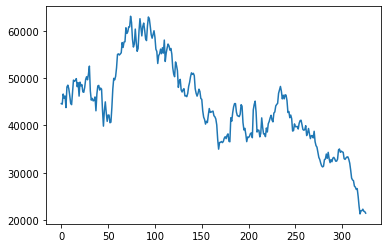

In [21]:
# Plots the predicted test values
plt.plot(y_predicted)
# Plots the true historic close values

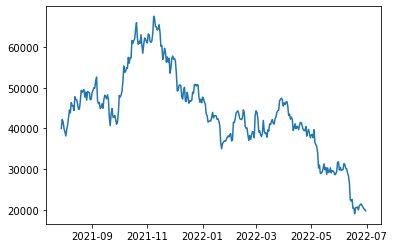

In [22]:
# Plots the true historic close values
plt.plot(df.iloc[760:]['close'])

In [39]:
y[-326]

array([43798.1171875])

760